## Modules needed

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import pickle

import warnings
warnings.filterwarnings('ignore')

## Dataset Read

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleaning

In [33]:
data.SeniorCitizen.replace({0:'No',1:'Yes'},inplace=True)

In [34]:
int_vals = []
non_int_vals = []
for val in data.TotalCharges.unique():
    try:
        int_vals.append(float(val))
    except:
        non_int_vals.append(val)
non_int_vals

[' ']

In [35]:
df_removed_records = data[data.TotalCharges == ' ']
df = data[data.TotalCharges != ' ']
df.TotalCharges = df.TotalCharges.astype('float64')

In [36]:
df.describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

In [37]:
obj_desc = df.describe(include='object').T
obj_desc['freq_perc'] = ((obj_desc['freq']/obj_desc['count'])*100)
obj_desc.sort_values(by=['unique','freq_perc'],inplace=True)
obj_desc

count unique               top  freq  freq_perc
gender            7032      2              Male  3549  50.469283
Partner           7032      2                No  3639  51.749147
PaperlessBilling  7032      2               Yes  4168    59.2719
Dependents        7032      2                No  4933  70.150739
Churn             7032      2                No  5163  73.421502
SeniorCitizen     7032      2                No  5890  83.759954
PhoneService      7032      2               Yes  6352   90.32992
StreamingMovies   7032      3                No  2781  39.547782
StreamingTV       7032      3                No  2809  39.945961
OnlineBackup      7032      3                No  3087  43.899317
DeviceProtection  7032      3                No  3094  43.998862
InternetService   7032      3       Fiber optic  3096  44.027304
MultipleLines     7032      3                No  3385  48.137088
TechSupport       7032      3                No  3472  49.374289
OnlineSecurity    7032      3                No  3497  49.729807
Contract          7032      3    Month-to-month  3875  55.105233
PaymentMethod     7032      4  Electronic check  2365  33.631968
customerID        7032   7032        7590-VHVEG     1   0.014221

In [38]:
df.set_index('customerID',inplace=True)

In [39]:
obj_cols = list(df.select_dtypes(include='object').columns)
for obj_col in obj_cols:
    print(obj_col,' - ',df[obj_col].unique())

gender  -  ['Female' 'Male']
SeniorCitizen  -  ['No' 'Yes']
Partner  -  ['Yes' 'No']
Dependents  -  ['No' 'Yes']
PhoneService  -  ['No' 'Yes']
MultipleLines  -  ['No phone service' 'No' 'Yes']
InternetService  -  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  -  ['No' 'Yes' 'No internet service']
OnlineBackup  -  ['Yes' 'No' 'No internet service']
DeviceProtection  -  ['No' 'Yes' 'No internet service']
TechSupport  -  ['No' 'Yes' 'No internet service']
StreamingTV  -  ['No' 'Yes' 'No internet service']
StreamingMovies  -  ['No' 'Yes' 'No internet service']
Contract  -  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  -  ['Yes' 'No']
PaymentMethod  -  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  -  ['No' 'Yes']


In [40]:
num_cols = list(df.select_dtypes(exclude='object').columns)
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

## Backing up details

## Loading backed up data

In [5]:
churn_df_details = pickle.load(open('churn_df_details.pkl','rb'))

In [45]:
df = churn_df_details['df']
obj_cols = churn_df_details['obj_cols']
num_cols = churn_df_details['num_cols']

## Data Visualization

In [12]:
plt.rcParams['font.size'] = '14'

### 1) Univariate Analysis

#### A) Numerical

In [ ]:
df.describe(percentiles=[0.1,0.2,0.25,0.5,0.75,0.9,0.95]).T

In [ ]:
plt.figure(figsize=(12,4))
sns.histplot(x=df['tenure'],bins=np.arange(0,75,3))
plt.xticks(np.arange(0,75,6))
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(x=df['MonthlyCharges'],bins=np.arange(0,120,10))
plt.xticks(np.arange(0,120,10))
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(x=df['TotalCharges'],bins=np.arange(0,9000,500))
plt.xticks(np.arange(0,9000,1000))
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
ax1,ax2,ax3= [plt.subplot(1,3,i+1) for i in range(3)]
axes = [ax1,ax2,ax3]

for axis, num_col in zip(axes,num_cols): 
    sns.boxplot(x=df[num_col],ax=axis)
#plt.savefig('Outliers_box_plot.jpg')
plt.tight_layout()
plt.show()

- Tenure :: peaks present in 0-6 months (new customers) and 69-72 months (long-term customers), remaining monthly bins nearly equally distributed
- MonthlyCharges :: peak present in 20-30 units and 70-100 units of currency
- TotalCharges :: Heavily left skewed, 50% of the customers have total charges less than 1400 units with the max value of 8684 units

- No outliers present in the numerical variables

#### B) Categorical

In [ ]:
plt.figure(figsize=(16,27))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18= [plt.subplot(9,2,i+1) for i in range(18)]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18]

for axis, obj_col in zip(axes,obj_cols): 
    sns.countplot(y=df[obj_col],ax=axis)
    #axis.set_yticklabels(axis.get_yticklabels(),rotation = 30)
    
plt.tight_layout()
#plt.savefig('Outliers_box_plot.jpg')
plt.show()

- Nearly equal % of males and females in the customers
- Most of the customers are not senior citizens and do not have dependents
- Relatively more number of customers do not have partners
- Most of the customers have subscribed to home phone service and in that relatively more number of customers are not subscribed for multiple lines
- More customers are subscibed to Fiber optic followed by DSL. Remaining are not subscribed for Internet Service.
- Most of the customers are not subscribed to Online Security, Online Backup, Device Protection, Streaming TV, Premium Tech Support or Streaming Movies
- Comparatively Streaming TV and Streaming Movies are the most subscribed services
- 55% of the customers are subscribed based on month to month contract
- 59% of the customers have chosen Paperless billing
- Most of the customers pays their bill through electronic check
- 26% of the customers have left the company (churn) this quarter

### 2) Bivariate Analysis

#### A) Between numerical variables

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
corre = df.corr()
sns.heatmap(corre,annot=True,cmap='seismic',vmin=-0.8,vmax=0.8,mask=np.triu(corre))
plt.show()

- High multicollinearity existing on the total charges variable with tenure and monthly charges

#### B) Numerical vs Categorical

In [ ]:
def numvscat(column):
    plt.figure(figsize=(16,27))
    ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18= [plt.subplot(9,2,i+1) for i in range(18)]
    axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18]

    for axis, obj_col in zip(axes,obj_cols): 
        sns.barplot(x=df[column],y=df[obj_col],ax=axis)
        #axis.set_yticklabels(axis.get_yticklabels(),rotation = 30)

    plt.tight_layout()
    #plt.savefig('Outliers_box_plot.jpg')
    plt.show()

##### 1. Tenure

In [ ]:
numvscat('tenure')

##### Average Tenure is relatively high for the customers 
- who are married or have dependendents
- who have subscribed for muliple lines or internet sevice
- who have opted for the other premium services
- who have subscribed based on Two year contract
- who pay bills automatically through bank transaction or credit card
- for obvious reasons, who do not churn

##### 2. Monthly Charges

In [ ]:
numvscat('MonthlyCharges')

##### Average Monthly Charges is relatively high for the customers 
- who are married or senior citizens
- who do not have dependents, surprisingly!
- who have subscribed for phone service or fiber optic internet sevice or muliple telephone lines 
- who have opted for the other premium services
- who have subscribed based on month to month contract
- who opt for paperless billing
- who pay bills using electronic check
- who left the company this quarter, again surprisingly!!

##### 3. TotalCharges

In [ ]:
numvscat('TotalCharges')

##### Average Total Charges is relatively high for the customers 
- who are married or senior citizens or have dependents
- who have subscribed for phone service or fiber optic internet sevice or muliple telephone lines 
- who have opted for the other premium services
- who have subscribed based on two year contract
- who opt for paperless billing
- who pay bills automatically through bank transaction or credit card
- for obvious reasons, who do not churn

#### C)  Categorical vs Numerical

In [ ]:
print(obj_cols)

In [ ]:
def catvsnum(column):
    plt.figure(figsize=(18,4))
    ax1,ax2,ax3= [plt.subplot(1,3,i+1) for i in range(3)]
    axes = [ax1,ax2,ax3]

    for axis, num_col in zip(axes,num_cols): 
        sns.barplot(y=df[column],x=df[num_col],ax=axis)

    #plt.savefig('Outliers_box_plot.jpg')
    plt.tight_layout()
    plt.show()

##### 1. gender

In [ ]:
catvsnum('gender')

- No distinction in numerical variables based on the gender of the customer

##### 2. SeniorCitizen

In [ ]:
catvsnum('SeniorCitizen')

- Though there is no distinction in avg tenure, avg Monthly Charges and avg Total Charges are high for senior citizens

##### 3. Partner

In [ ]:
catvsnum('Partner')

- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who are married

##### 4. Dependents

In [ ]:
catvsnum('Dependents')

- Avg Montly charges are high for customers who do not have dependents
- Avg Tenure and avg Total Charges are high for customers who have dependents

##### 5. PhoneService

In [ ]:
catvsnum('PhoneService')

- Though there is no distinction in avg tenure, avg Monthly Charges and avg Total Charges are high for customers who are subscribed to phone service

##### 6. MultipleLines

In [ ]:
catvsnum('MultipleLines')

- Avg Tenure and Avg Total charges is the least for the customers who have subscribed for phone service but not for Multiple telephone lines
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Multiple telephone lines

##### 7. InternetService

In [ ]:
catvsnum('InternetService')

- Average tenure is high for the customers who have suscribed for Internet service
- Average Monthly charges and Total charges are high for customers who opted for Fiber optic followed by DSL

##### 8. OnlineSecurity

In [ ]:
catvsnum('OnlineSecurity')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Online Security
- Avg Tenure and avg Total Charges are high for customers who have subscribed for Online Security
- Avg Monthly Charges is high for customers who have opted for internet service

##### 9. OnlineBackup

In [ ]:
catvsnum('OnlineBackup')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Online Backup
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Online Backup

##### 10. DeviceProtection

In [ ]:
catvsnum('DeviceProtection')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Device protection
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Device protection

##### 11. TechSupport

In [ ]:
catvsnum('TechSupport')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Premium Tech Support
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Premium Tech Support

##### 12. StreamingTV

In [ ]:
catvsnum('StreamingTV')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Streaming TV
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Streaming TV

##### 13. StreamingMovies

In [ ]:
catvsnum('StreamingMovies')

- Avg Tenure is the least for the customers who have subscribed for internet service but not for Streaming Movies
- Avg Tenure, avg Monthly Charges and avg Total Charges are high for customers who have subscribed for Streaming Movies

##### 14. Contract

In [ ]:
catvsnum('Contract')

- Avg Tenure and avg Total Charges for customers based on their contract in the following order : Two year > One year > Month-to-month
- Avg Monthly Charges is high for customers who have subscribed based on Month-to-month or One year contract

##### 15. PaperlessBilling

In [ ]:
catvsnum('PaperlessBilling')

- Though there is no distinction in avg tenure, avg Monthly Charges and avg Total Charges are high for customers who opted for Paperless billing

##### 16. PaymentMethod

In [ ]:
catvsnum('PaymentMethod')

- Avg Tenure and avg Total Charges for customers based on their payment order in the following order : Automatic(Bank transfer/Credit Card) > Electronic check > Mailed check
- avg Monthly Charges for customers based on their payment order in the following order : Electronic check > Automatic(Bank transfer/Credit Card) > Mailed check

#### D)  Categorical vs Categorical

In [ ]:
def catvscat(column):
    temp_obj_cols = obj_cols.copy()
    temp_obj_cols.remove(column)

    plt.figure(figsize=(24,24))
    ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16= [plt.subplot(8,2,i+1) for i in range(16)]
    axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16]

    for axis, obj_col in zip(axes,temp_obj_cols): 
        cross_tab_prop = pd.crosstab(df[column],df[obj_col],normalize='index')
        cross_tab_prop.plot(kind='barh',stacked=True,ax=axis)
        axis.legend(loc="center",ncol=1,fontsize='x-small',bbox_to_anchor=(1.15, 0.8))
        axis.set_xlabel(f'Ratio of {obj_col}')
        
        #sns.countplot(y=df[column],hue=df[obj_col],ax=axis)

    #plt.savefig('Outliers_box_plot.jpg')
    plt.tight_layout()
    plt.show()

##### 1. gender

In [ ]:
catvscat('gender')

- No distinction based on gender in any of the categorical variables

##### 2. SeniorCitizen

In [ ]:
catvscat('SeniorCitizen')

For customers who are **SeniorCitizens**,
- the ratio of dependents are high
- the ratio of subscription to Multiple telephone lines is high
- the ratio of subscription to Fiber optic Internet Service is high
- the ratio of subscription to premium services such as OnlineBackup, DeviceProtection, StreamingTV and StreamingMovies are high where to OnlineSecurity and PremiumTechSupport are low
- ratio of Month-to-month contract is high
- ratio of Paperless Billing is high
- ratio of payment by Electronic Check is high
- ratio of **churn rate** is high

##### 3. Partner

In [ ]:
catvscat('Partner')

For customers who are **married**,
- the ratio of dependents are high
- the ratio of subscription to Multiple telephone lines is high
- the ratio of subscription to all the premium services are high
- ratio of Two year contract is high
- ratio of automatic payment(Bank-transfer/Credit-card) is high

For customers who are **not married**,
- ratio of **churn rate** is high

##### 4. Dependents

In [ ]:
catvscat('Dependents')

For customers who lives with any **dependents**,
- the ratio of martial status being married is high
- the ratio of subscription to all the premium services except StreamingTV and StreamingMovies are high
- ratio of Two year contract is high
- ratio of automatic payment(Bank-transfer/Credit-card) is high

For customers who lives with any **dependents**,
- the ratio of senior citizens is high
- the ratio of subscription to fiber optic internet service is high
- the ratio of opting to Paperless billing is high
- ratio of **churn rate** is high

##### 5. PhoneService

In [ ]:
catvscat('PhoneService')

For customers who have subscribed for **Phone Service**,
- the ratio of martial status being married is high

For customers who have **not** subscribed for **Phone Service**,
- but subscribed for internet service, all of them use DSL internet service
- the ratio of subscription to premium services is constant across

##### 6. MultipleLines

In [ ]:
catvscat('MultipleLines')

For customers who are subscribed with **multiple telephone lines**,
- the ratio of senior citizens is high
- the ratio of martial status being married is high
- the ratio of subscription to fiber optic internet service is high
- the ratio of subscription to all the premium services except StreamingTV and StreamingMovies are high
- ratio of Two year contract is high
- the ratio of opting to Paperless billing is high
- ratio of automatic payment(Bank-transfer/Credit-card) is high

For customers who are **not** subscribed with **multiple telephone lines**,
- ratio of payment through mailed check is high

##### 7. InternetService

In [ ]:
catvscat('InternetService')

1) Fiber optic > DSL > No internet service
- the ratio of senior citizens
- the ratio of customers with dependents
- the ratio of subscription to multiple telephone lines
- the ratio of **Month-to-month** contract
- the ratio of payment method by **Electronic check**
- the ratio of subscription to **paperless billing** and 
- the ratio of **churn rate**

2) Fiber optic > DSL
- the ratio of subscription to all the premium services such as StreamingTV and StreamingMovies

3) DSL > No internet service > Fiber optic
- the ratio of **automatic payment** method

4) DSL > Fiber optic
- the ratio of subscription to all the premium services such as OnlineSecurity and premium Tech support

5) No internet service > DSL > Fiber optic
- the ratio of **two year** contract
- the ratio of payment method by **mailed check** 

Other inferences
- All the customers who are subscribed for **InternetService** with **Fiber-optic** are subscribed to phone service 
- Some of the customers who are subscribed for **InternetService** with **DSL** do not have subscription to phone service

##### 8. OnlineSecurity

In [ ]:
catvscat('OnlineSecurity')

For customers who are subscribed for **OnlineSecurity**,
- the ratio of martial status as married is high
- the ratio of living with dependents is high
- the ratio of subscription to the premium services such as OnlineBackup, DeviceProtection and premium Tech support are high
- the ratio of two year contract mode is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **OnlineSecurity**,
- the ratio of senior citizens is high
- the ratio of subscription to internet service by Fiber-optic is high
- the ratio of Month-to-month contract mode is high
- the ratio of subscription to Paperless billing is high
- the ratio of payment by Electronic check is high
- the ratio of **churn rate** is high

##### 9. OnlineBackup

In [ ]:
catvscat('OnlineBackup')

For customers who are subscribed for **OnlineBackup**,
- the ratio of martial status as married is high
- the ratio of living with dependents is high
- the ratio of subscription to all the premium services are high
- the ratio of two year contract mode is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **OnlineBackup**,
- the ratio of Month-to-month contract mode is high
- the ratio of payment by Electronic check is high
- the ratio of **churn rate** is high

##### 10. DeviceProtection

In [ ]:
catvscat('DeviceProtection')

For customers who are subscribed for **DeviceProtection**,
- the ratio of martial status as married is high
- the ratio of living with dependents is high
- the ratio of subscription to multiple telephone lines is high
- the ratio of subscription to all the premium services are high
- the ratio of two year contract mode is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **DeviceProtection**,
- the ratio of Month-to-month contract mode is high
- the ratio of payment by Electronic check is high
- the ratio of **churn rate** is high

##### 11. TechSupport

In [ ]:
catvscat('TechSupport')

For customers who are subscribed for **Premium TechSupport**,
- the ratio of martial status as married is high
- the ratio of living with dependents is high
- the ratio of subscription to all the premium services are high
- the ratio of two year contract mode is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **Premium TechSupport**,
- the ratio of senior citizens is high
- the ratio of subscription internet service with Fiber-optic is high
- the ratio of Month-to-month contract mode is high
- the ratio of subscription to paperless billing is high
- the ratio of payment by Electronic check is high
- the ratio of **churn rate** is high

##### 12. StreamingTV

In [ ]:
catvscat('StreamingTV')

For customers who are subscribed for **StreamingTV**,
- the ratio of martial status as married is high
- the ratio of subscription to multiple telephone lines is high
- the ratio of subscription internet service with Fiber-optic is high
- the ratio of subscription to all the premium services are high
- the ratio of two year contract mode is high
- the ratio of subscription to paperless billing is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **StreamingTV**,
- the ratio of Month-to-month contract mode is high
- the ratio of **churn rate** is high

##### 13. StreamingMovies

In [ ]:
catvscat('StreamingMovies')

For customers who are subscribed for **StreamingMovies**,
- the ratio of senior citizens is high
- the ratio of martial status as married is high
- the ratio of subscription to multiple telephone lines is high
- the ratio of subscription internet service with Fiber-optic is high
- the ratio of subscription to all the premium services are high
- the ratio of two year contract mode is high
- the ratio of subscription to paperless billing is high
- the ratio of automatic payment is high

For customers who are **not** subscribed for **StreamingMovies**,
- the ratio of Month-to-month contract mode is high
- the ratio of **churn rate** is high

##### 14. Contract

In [ ]:
catvscat('Contract')

1) Two year > One year > Month-to-month
- the ratio of **senior citizens** customers
- the ratio of subscription to **multiple telephone** lines
- the ratio of subscription to the premium services such as Device Protection and premium TechSupport
- the ratio of using **automatic payment** method

2) Two year = One year > Month-to-month 
- the ratio of subscription to the premium services such as Online Backup, StreamingTV and StreamingMovies

3) Month-to-month > One year > Two year
- the ratio of customers living with **dependents**
- the ratio of **married** customers
- the ratio of internet service using **Fiber optic**
- the ratio of subscription to **paperless billing**
- the ratio of payment by **electronic check**
- the ratio of **churn rate** is high

##### 15. PaperlessBilling

In [ ]:
catvscat('PaperlessBilling')

For customers who are subscribed for **PaperlessBilling**,
- the ratio of senior citizens is high
- the ratio of subscription to multiple telephone lines is high
- the ratio of subscription internet service with Fiber-optic is high
- the ratio of subscription to all the premium services except OnlineSecurity are high
- the ratio of Month-to-month contract mode is high
- the ratio of payment by electronic check is high
- the ratio of **churn rate** is high

For customers who are **not** subscribed for **PaperlessBilling**,
- the ratio of customers with dependents is high
- the ratio of non subscription to internet service is high
- the ratio of two year contract mode is high
- the ratio of payment by mail check is high

##### 16. PaymentMethod

In [ ]:
catvscat('PaymentMethod')

1) Electronic > Automatic > Mail
- the ratio of **married** customers
- the ratio of internet service using **Fiber optic**
- the ratio of subscription to the premium services such as StreamingTV and StreamingMovies
- the ratio of subscription to **paperless billing**

2) Electronic > Mail > Automatic
- the ratio of **Month-to-month** contract mode

3) Automatic > Electronic > Mail
- the ratio of **senior citizen** customers
- the ratio of subscription to the premium services such as OnlineBackup and DeviceProtection

4) Automatic > Mail > Electronic
- the ratio of **Two year** contract mode

5) Automatic > Manual
- the ratio of subscription to the premium services such as OnlineSecurity and premium TechSupport

Other inferences
- the ratio of customers living with **dependents** is low for those who pay with **Electronic check**
- the ratio of **churn rate** is high for customers who pay with **Electronic check**
- the ratio of subscription to **multiple telephone** lines is low for those who pay with **Mailed check**

### E) Against Target Variable

##### 1) Numerical Variables

In [ ]:
catvsnum('Churn')

For customers who churn
- Average tenure and average total charges is low
- But, Average monthly charges is high

##### 2) Categorical Variables

In [ ]:
catvscat('Churn')

For customers who **left (churn)** company this quarter,
- the ratio of senior citizens is high
- the ratio of subscription internet service with Fiber-optic is high
- the ratio of subscription to the premium non streaming services are **low**
- the ratio of Month-to-month contract mode is high
- the ratio of subscription to paperless billing is high
- the ratio of payment by Electronic check is high

For customers who have **not left** company this quarter,
- the ratio of martial status as married is high
- the ratio of customers with dependents
- the ratio of two year contract mode is high
- the ratio of automatic payment and mailed check is high

### 3) Multivariate analysis

#### A) Between numerical vs target

In [ ]:
sns.pairplot(df,hue='Churn')

#### B) Num vs Cat vs Target

In [ ]:
imp_cols_cat = ['SeniorCitizen','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                'Contract', 'PaperlessBilling', 'PaymentMethod']

In [ ]:
def catvsnum_hued(x_col,y_col,hue_col):
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[y_col],x=df[x_col],hue=df[hue_col])
    plt.legend(bbox_to_anchor=(1,1))

    #plt.savefig('Outliers_box_plot.jpg')
    plt.show()

In [ ]:
for y_col in obj_cols:
    catvsnum_hued('tenure',y_col,'Churn')

In [ ]:
for y_col in obj_cols:
    catvsnum_hued('MonthlyCharges',y_col,'Churn')

In [ ]:
for y_col in obj_cols:
    catvsnum_hued('TotalCharges',y_col,'Churn')

#### C)  Cat vs Num vs Target

##### 1. gender

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'gender','Churn')

##### 2. SeniorCitizen

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'SeniorCitizen','Churn')

##### 3. Partner

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'Partner','Churn')

##### 4. Dependents

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'Dependents','Churn')

##### 5. PhoneService

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'PhoneService','Churn')

##### 6. MultipleLines

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'MultipleLines','Churn')

##### 7. InternetService

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'InternetService','Churn')

##### 8. OnlineSecurity

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'OnlineSecurity','Churn')

##### 9. OnlineBackup

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'OnlineBackup','Churn')

##### 10. DeviceProtection

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'DeviceProtection','Churn')

##### 11. TechSupport

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'TechSupport','Churn')

##### 12. StreamingTV

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'StreamingTV','Churn')

##### 13. StreamingMovies

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'StreamingMovies','Churn')

##### 14. Contract

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'Contract','Churn')

##### 15. PaperlessBilling

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'PaperlessBilling','Churn')

##### 16. PaymentMethod

In [ ]:
for x_col in num_cols:
    catvsnum_hued(x_col,'PaymentMethod','Churn')

#### D) Between Categorical vs Target

In [13]:
def catvscat_hued_act(cat_col_1, cat_col_2, target): 
    a, b = cat_col_1, cat_col_2
    ab = a+'_'+b
    col_name = target+'_perc'
    
    df_groupby = df.groupby([a,b])[target].value_counts().mul(100).rename(col_name).reset_index()
    df_groupby.insert(0,ab,df_groupby[a] + '_' + df_groupby[b])
    df_groupby.drop(columns=[a,b],inplace=True)
    cross_tab_prop = pd.crosstab(index=df_groupby[ab],columns=df_groupby[target],values=df_groupby[col_name],aggfunc=np.sum,normalize='index')
    
    cross_tab_prop.plot(kind='barh',stacked=True)
    plt.legend(loc="center",ncol=1,fontsize='x-small',bbox_to_anchor=(1.15, 0.8))
    plt.xlabel(f'Ratio of {col_name}')
    #plt.savefig('Outliers_box_plot.jpg')
    plt.show()

def catvscat_hued(imp_cols_cat,focus_col,target_col):
    temp_obj_cols = imp_cols_cat.copy()
    temp_obj_cols.remove(focus_col)
    for col in temp_obj_cols:
        catvscat_hued_act(col,focus_col,target_col)

##### 1. gender

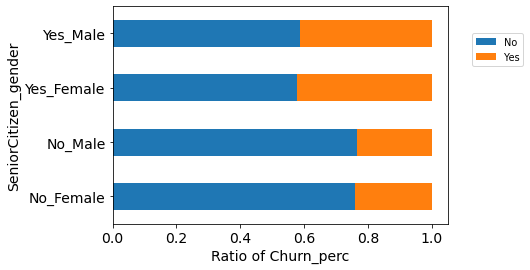

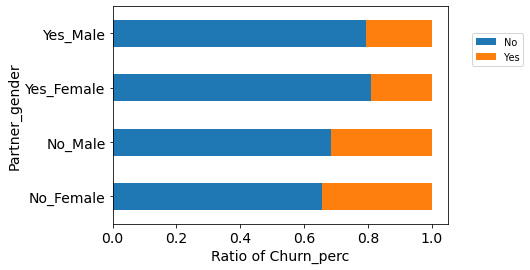

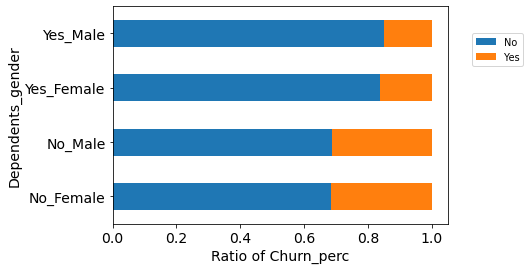

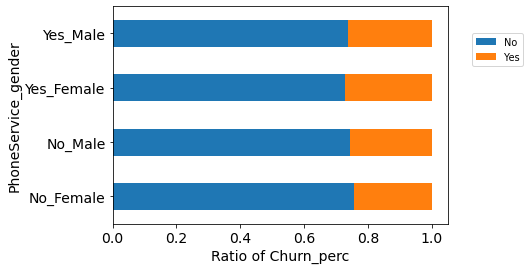

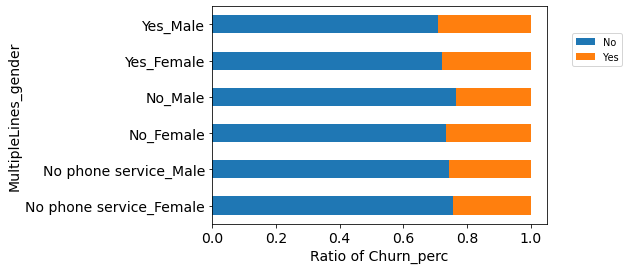

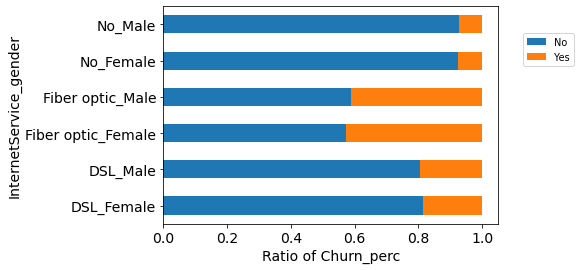

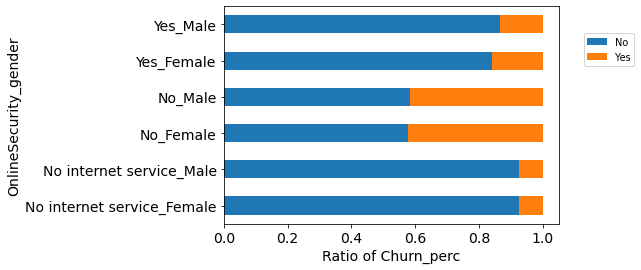

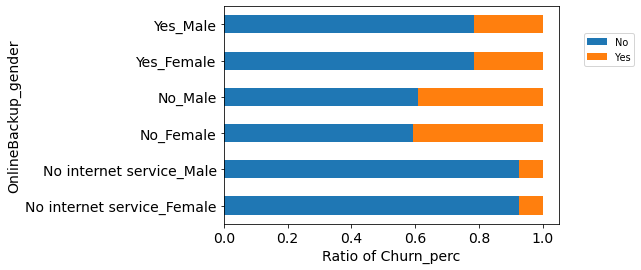

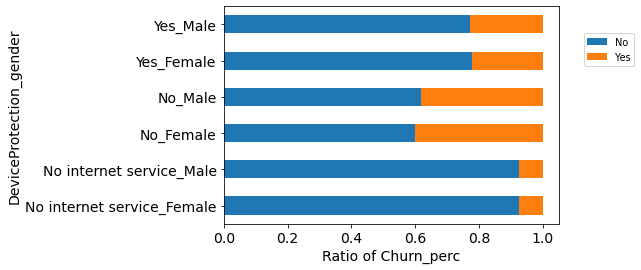

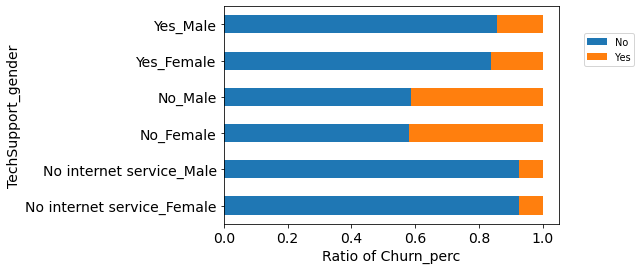

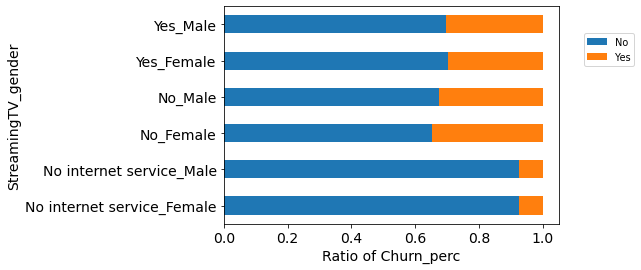

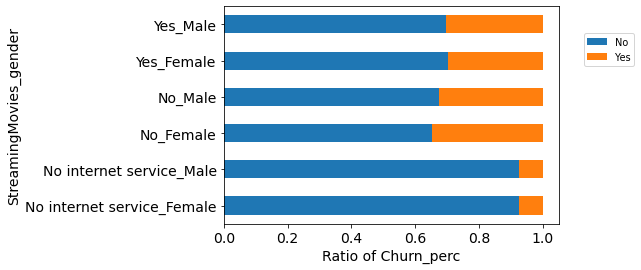

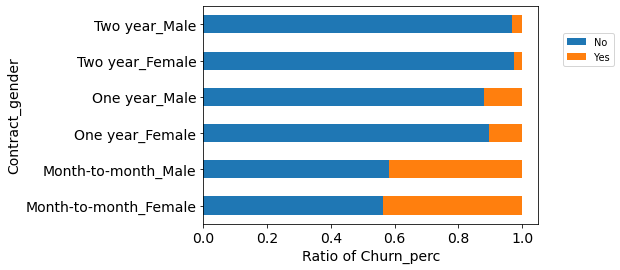

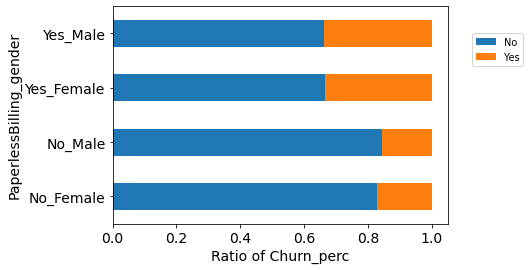

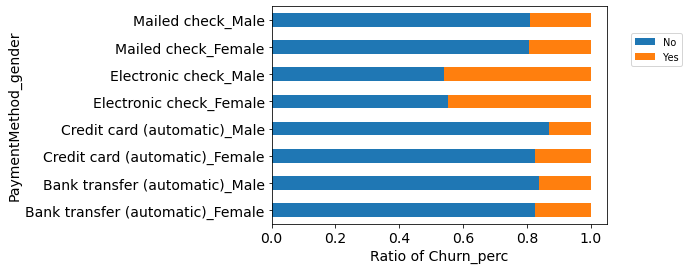

ValueError: cannot insert Churn, already exists

In [14]:
catvscat_hued(obj_cols,'gender','Churn')

##### 2. SeniorCitizen

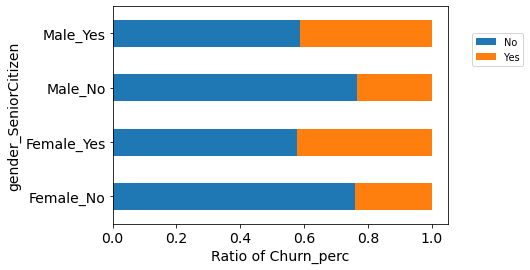

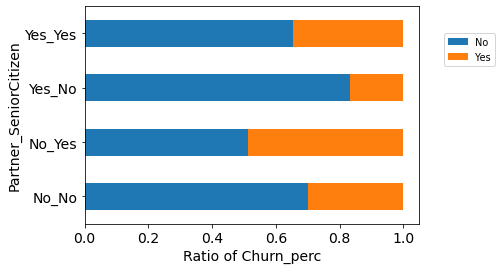

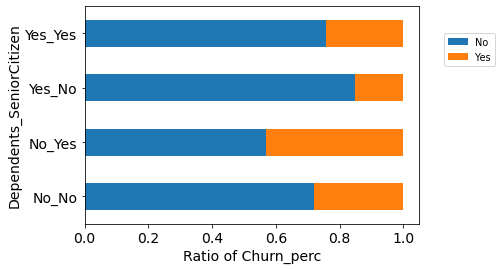

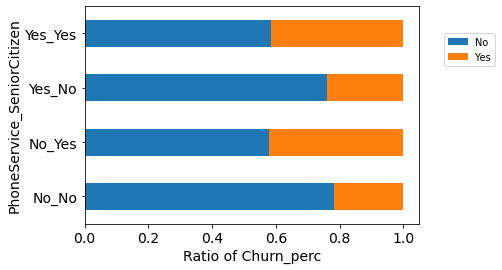

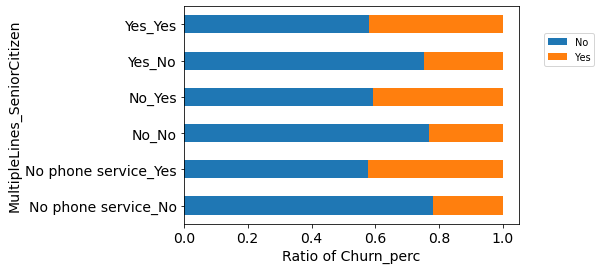

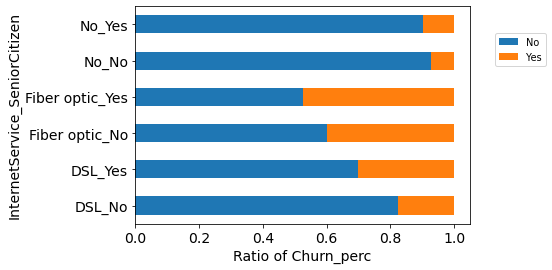

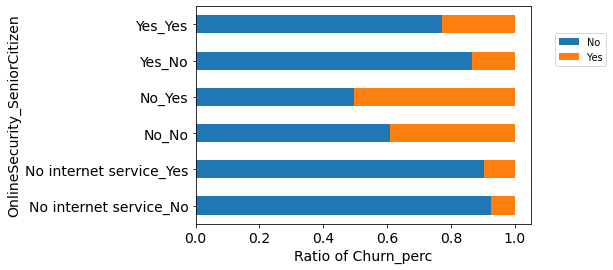

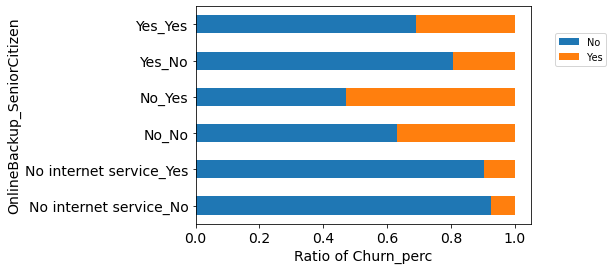

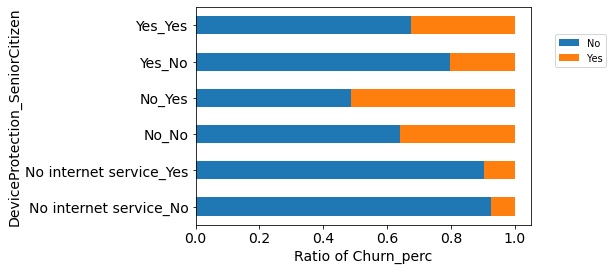

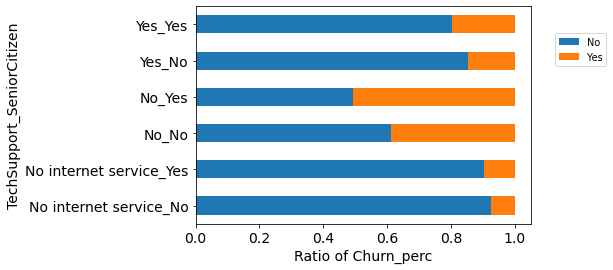

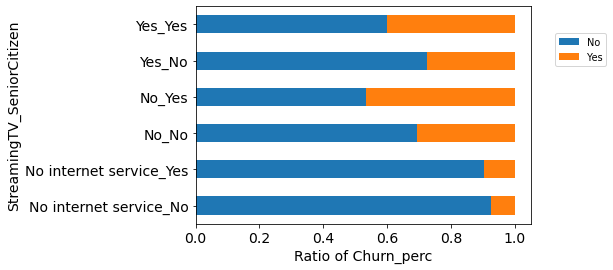

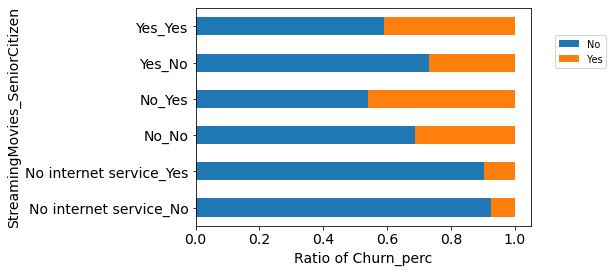

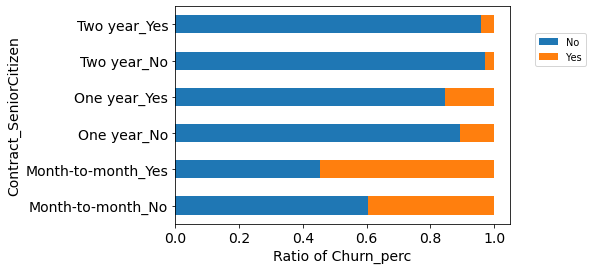

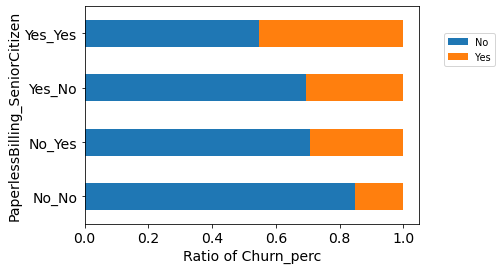

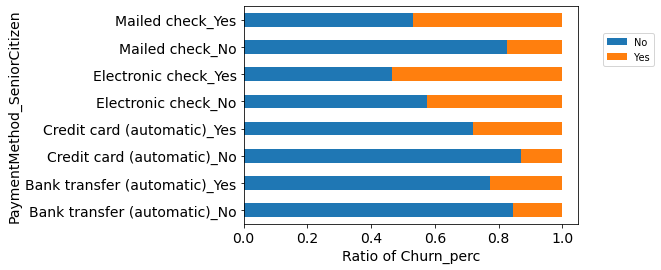

ValueError: cannot insert Churn, already exists

In [15]:
catvscat_hued(obj_cols,'SeniorCitizen','Churn')

##### 3. Partner

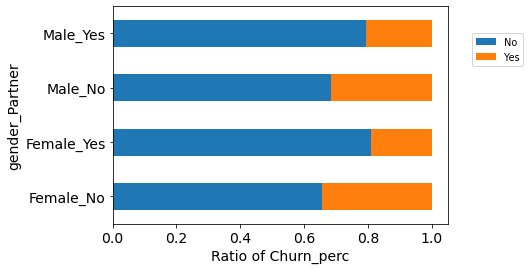

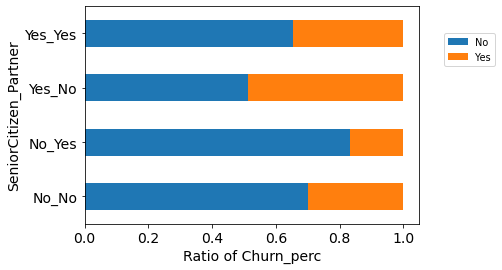

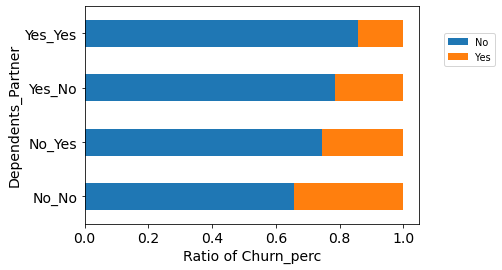

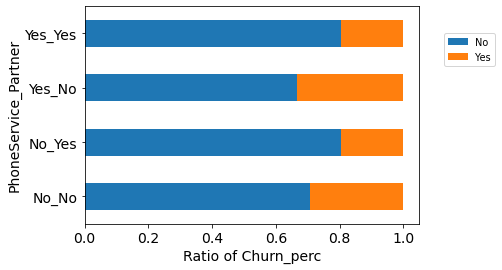

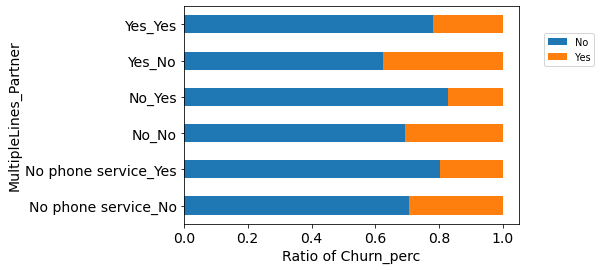

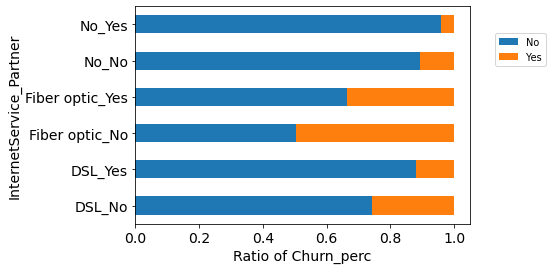

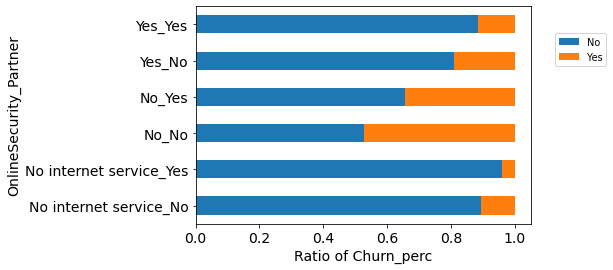

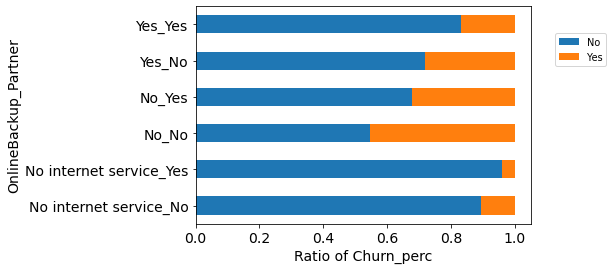

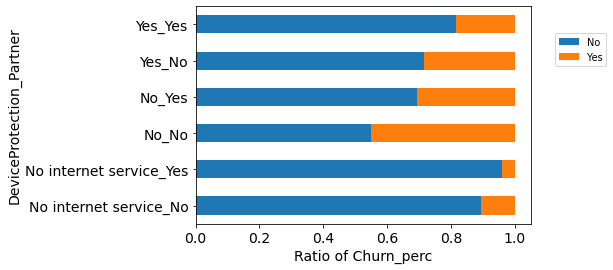

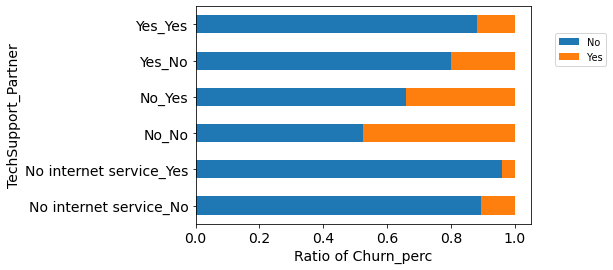

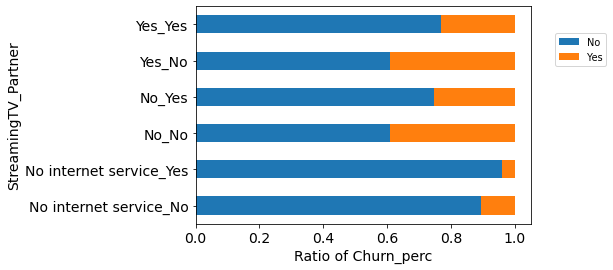

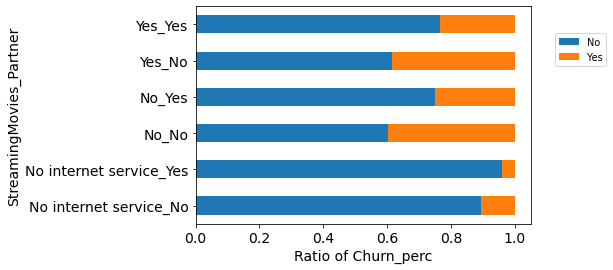

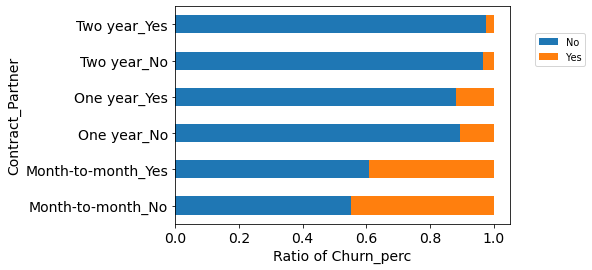

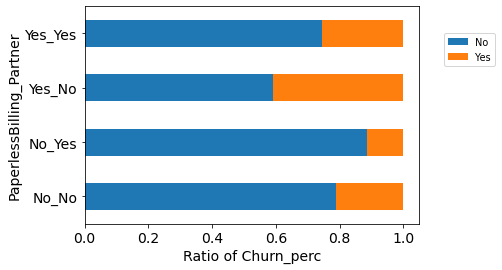

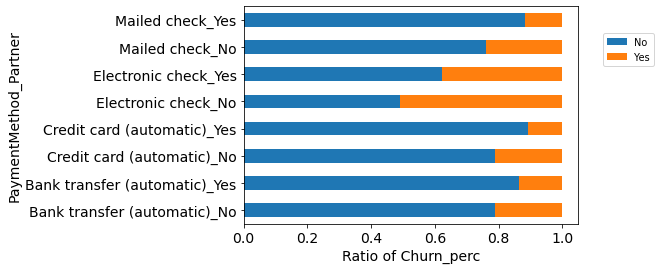

ValueError: cannot insert Churn, already exists

In [16]:
catvscat_hued(obj_cols,'Partner','Churn')

##### 4. Dependents

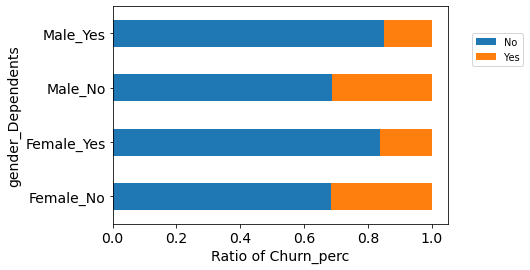

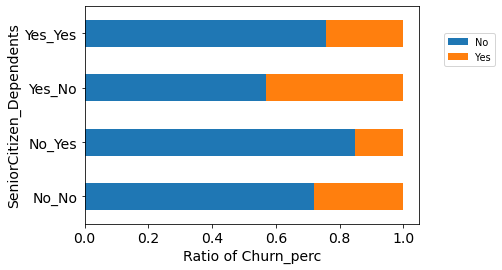

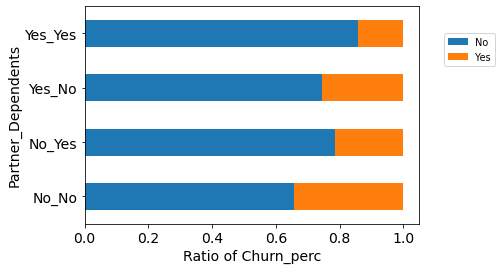

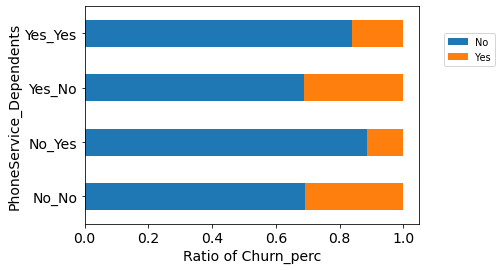

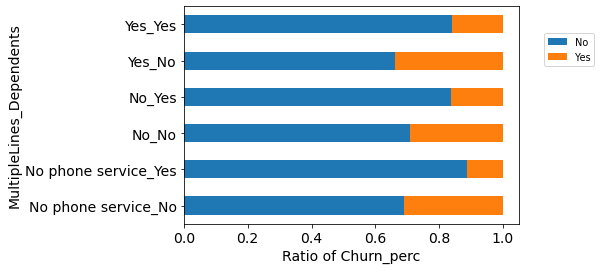

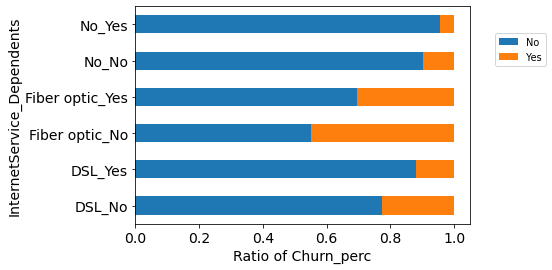

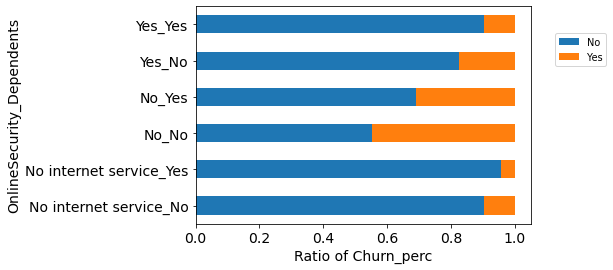

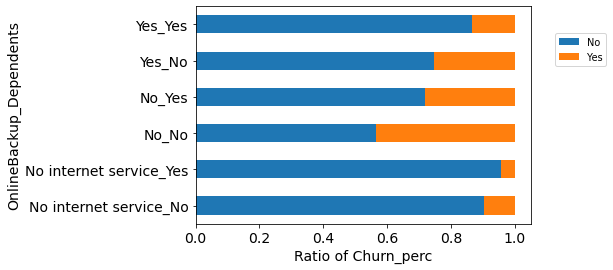

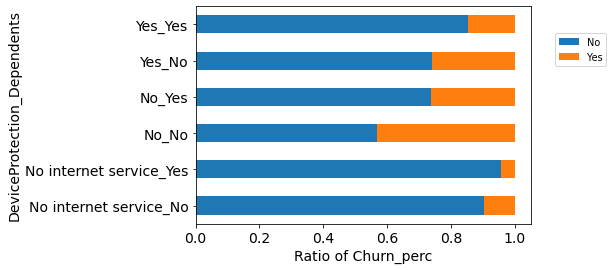

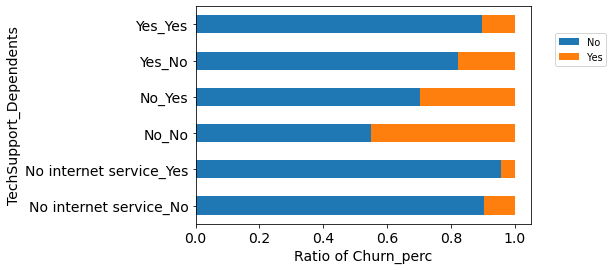

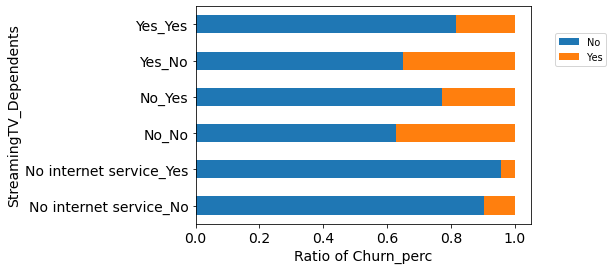

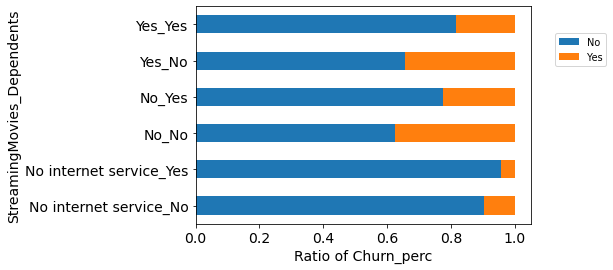

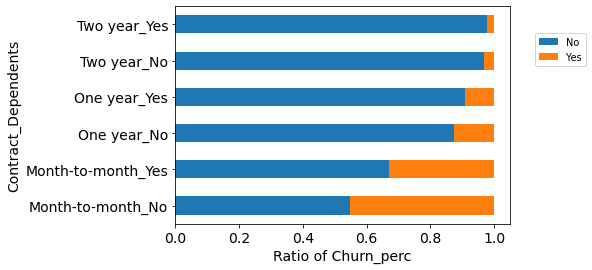

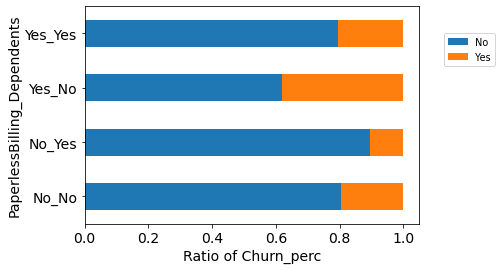

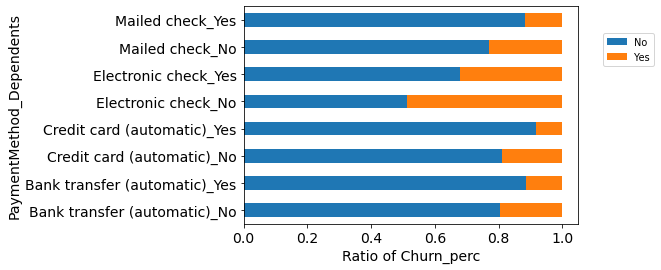

ValueError: cannot insert Churn, already exists

In [17]:
catvscat_hued(obj_cols,'Dependents','Churn')

##### 5. PhoneService

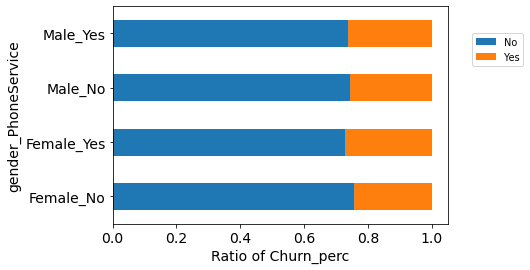

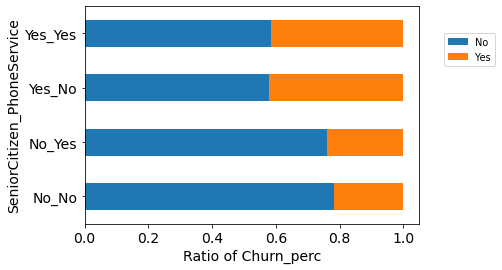

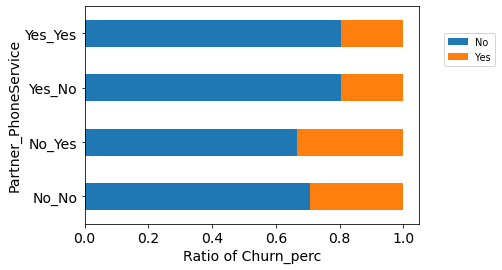

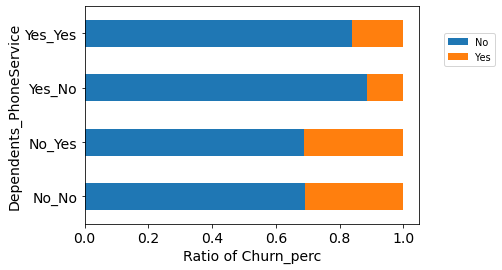

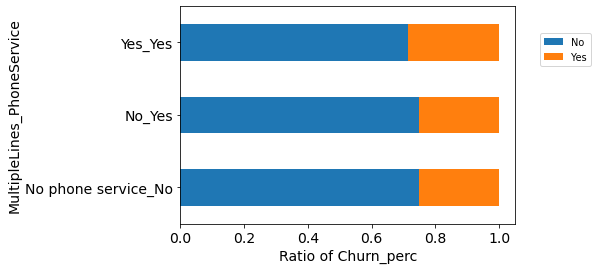

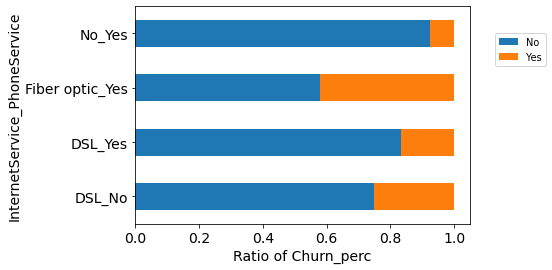

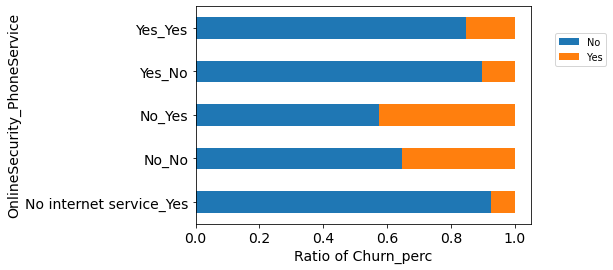

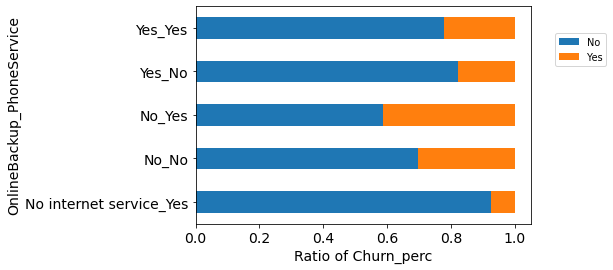

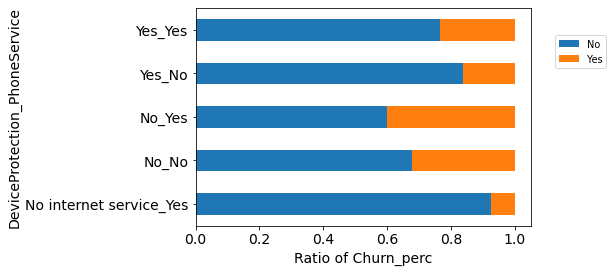

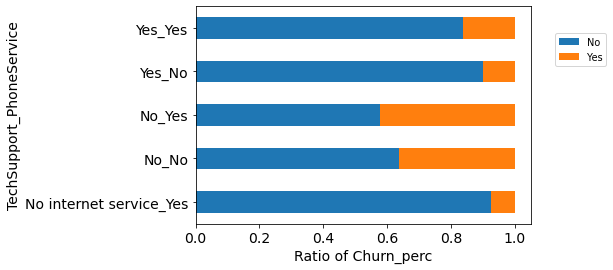

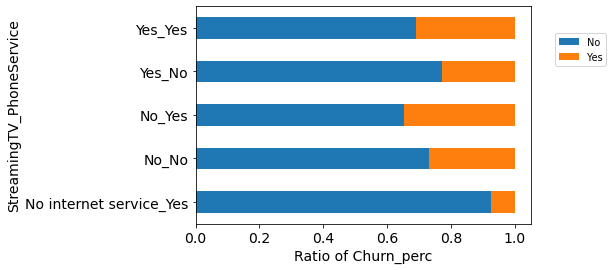

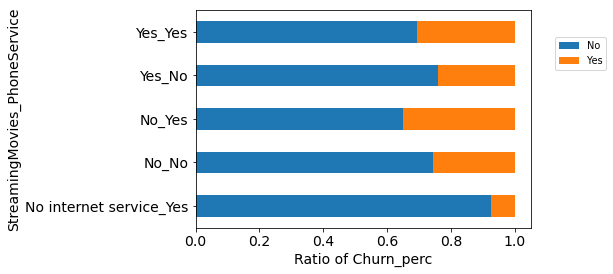

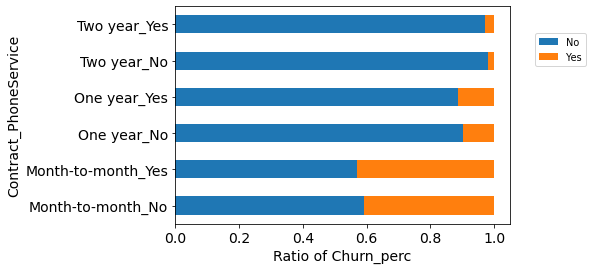

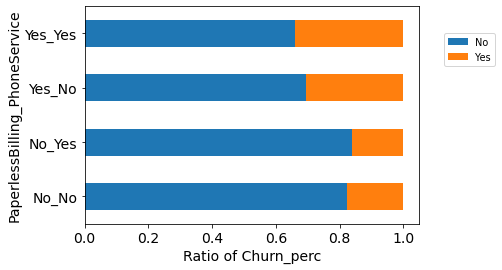

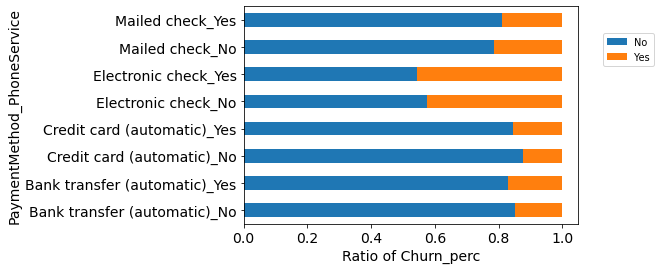

ValueError: cannot insert Churn, already exists

In [18]:
catvscat_hued(obj_cols,'PhoneService','Churn')

##### 6. MultipleLines

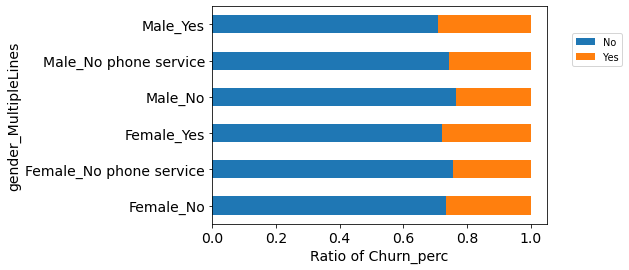

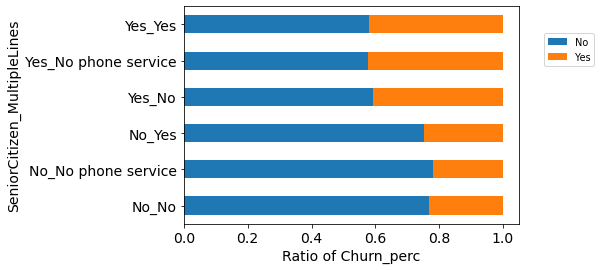

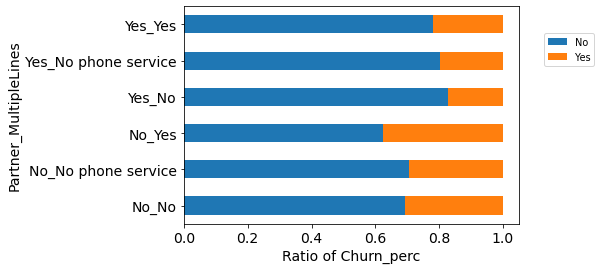

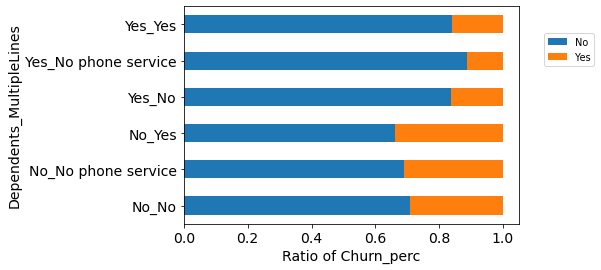

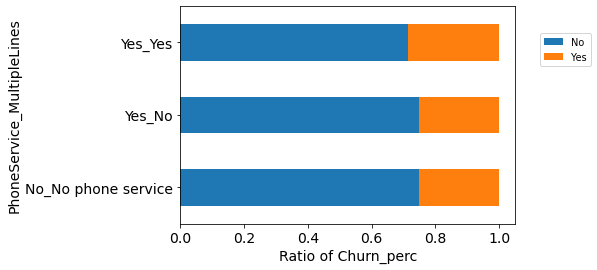

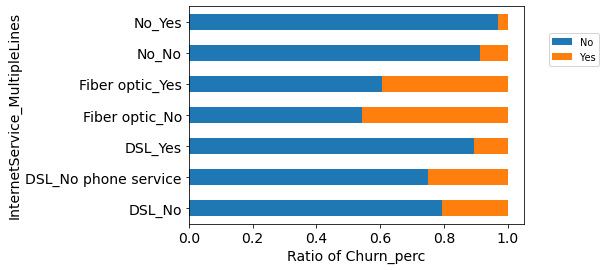

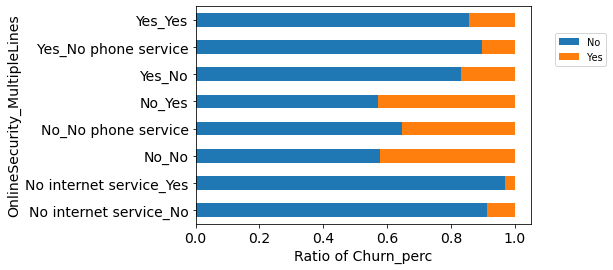

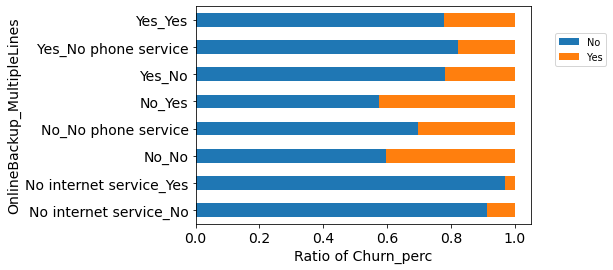

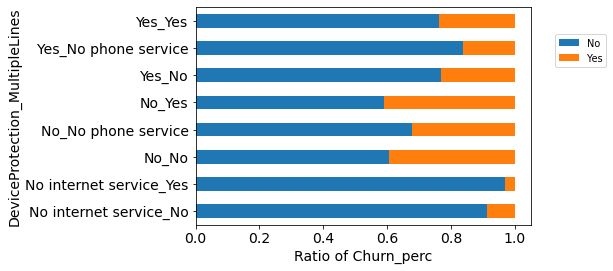

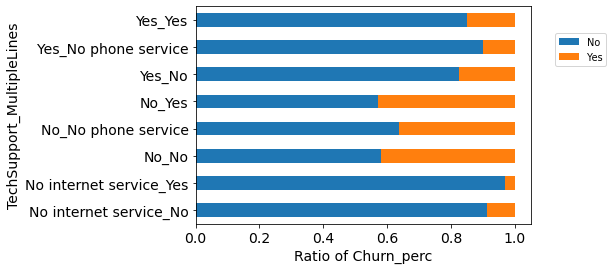

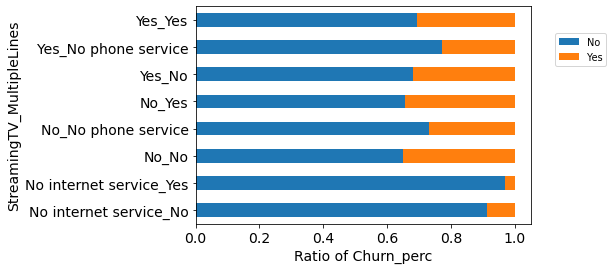

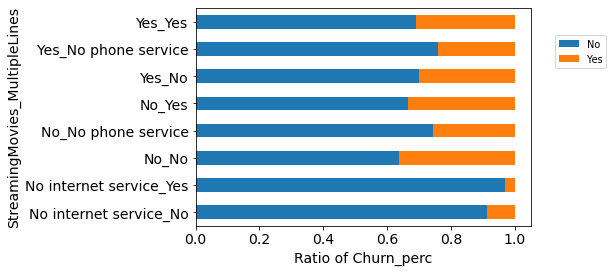

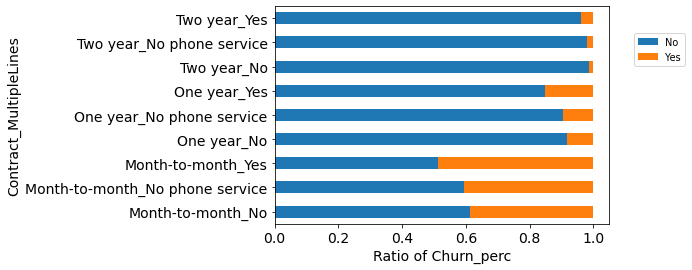

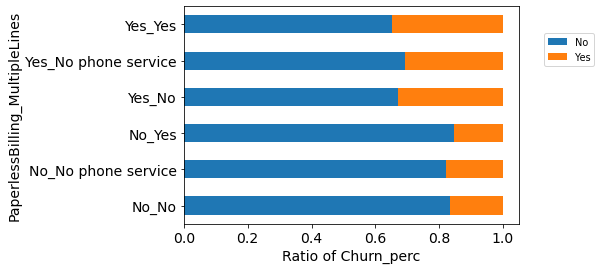

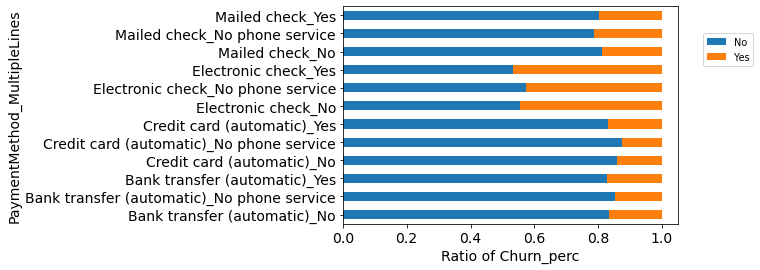

ValueError: cannot insert Churn, already exists

In [19]:
catvscat_hued(obj_cols,'MultipleLines','Churn')

##### 7. InternetService

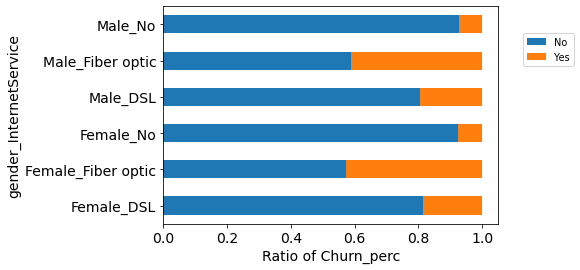

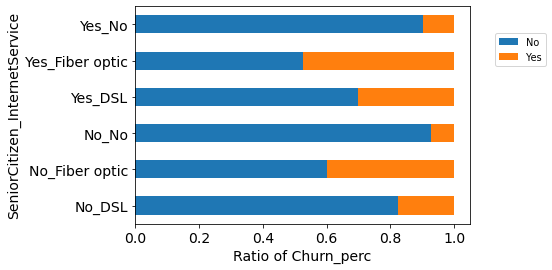

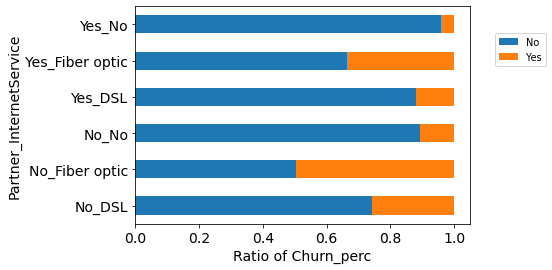

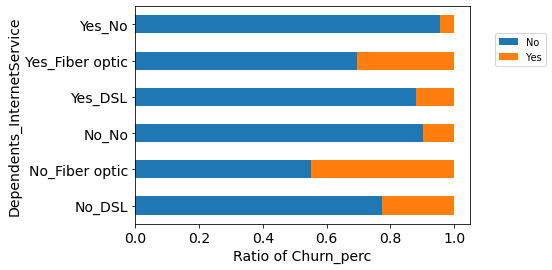

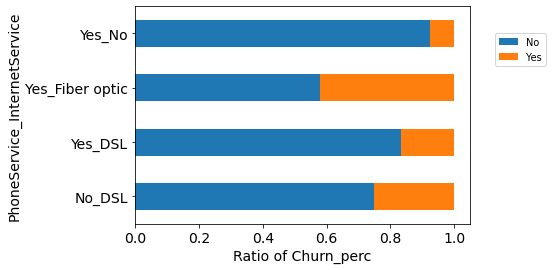

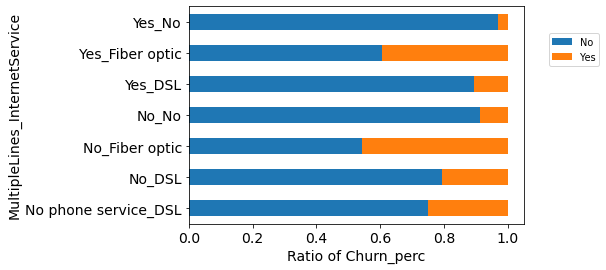

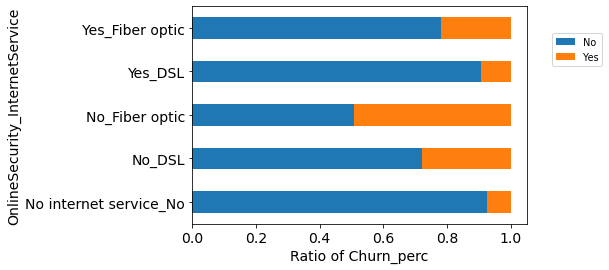

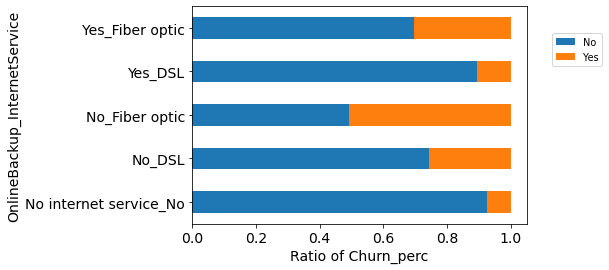

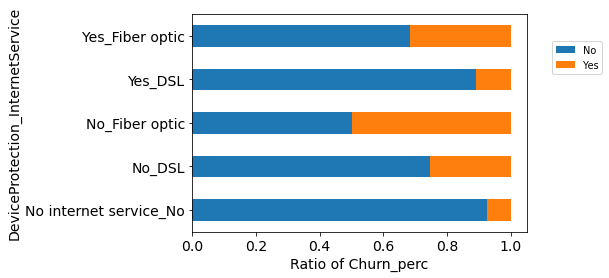

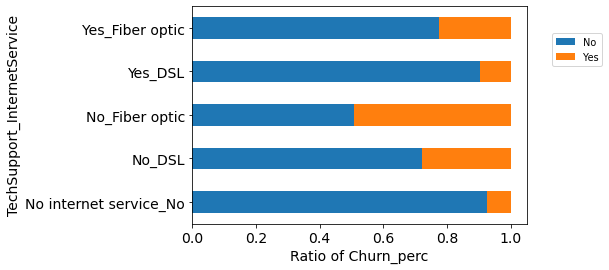

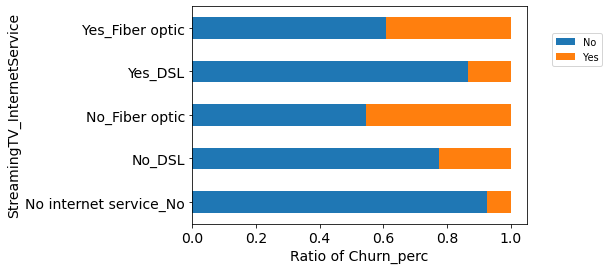

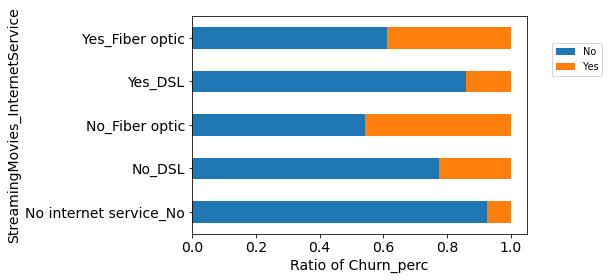

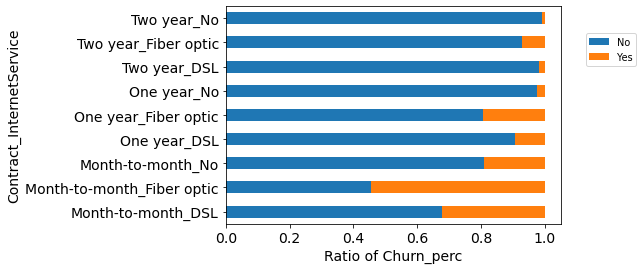

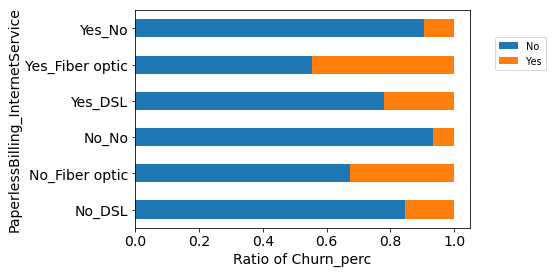

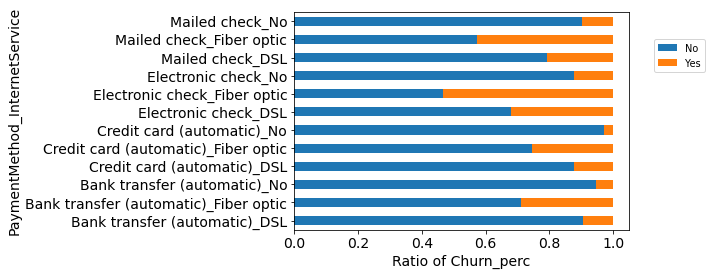

ValueError: cannot insert Churn, already exists

In [20]:
catvscat_hued(obj_cols,'InternetService','Churn')

##### 8. OnlineSecurity

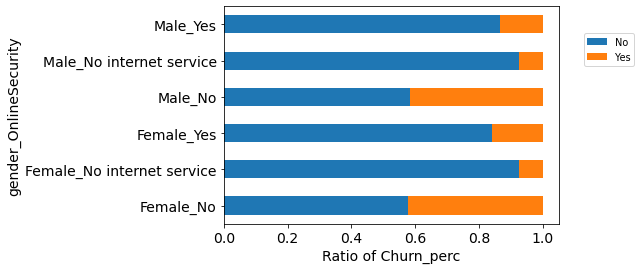

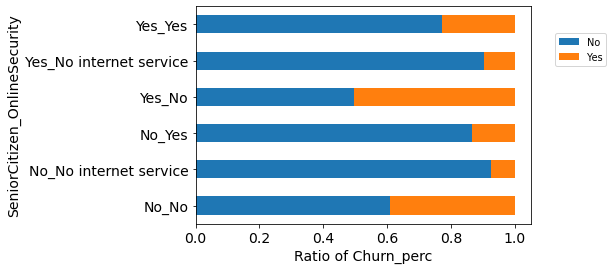

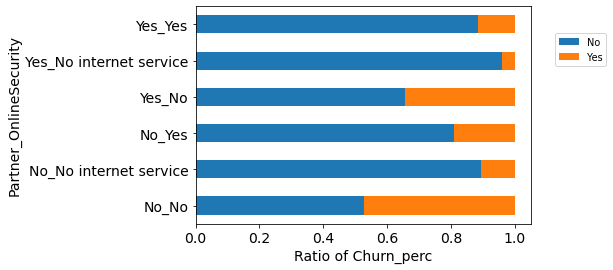

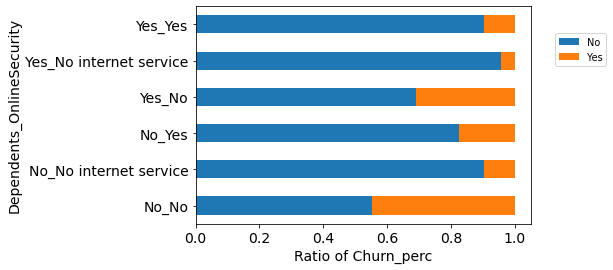

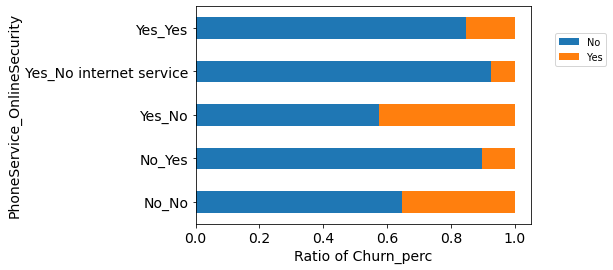

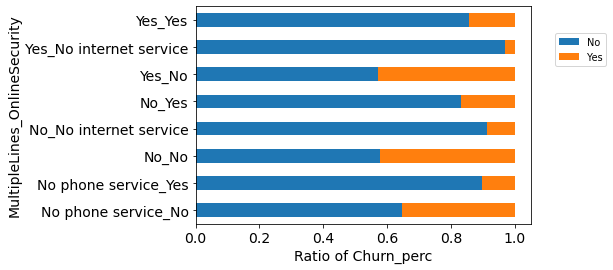

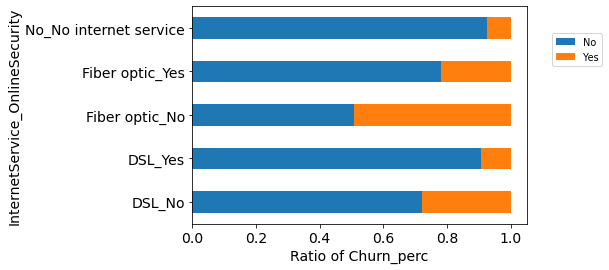

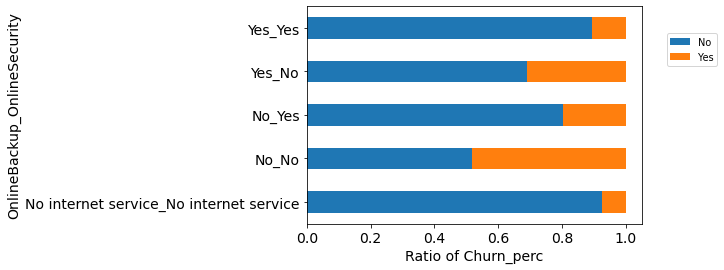

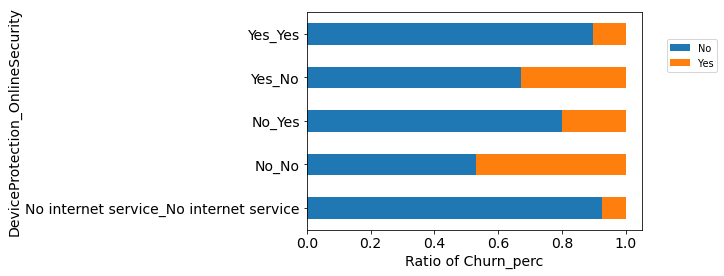

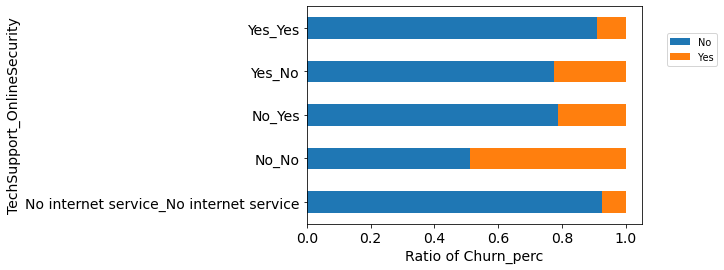

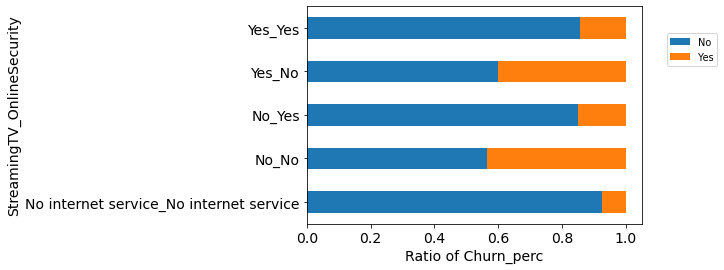

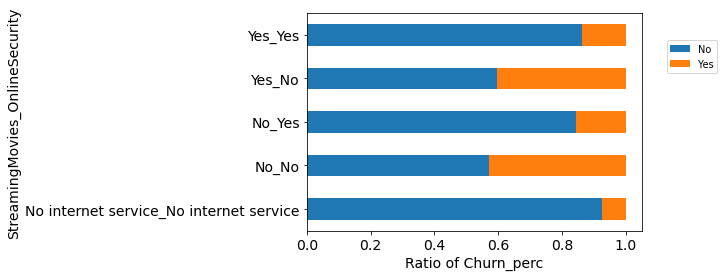

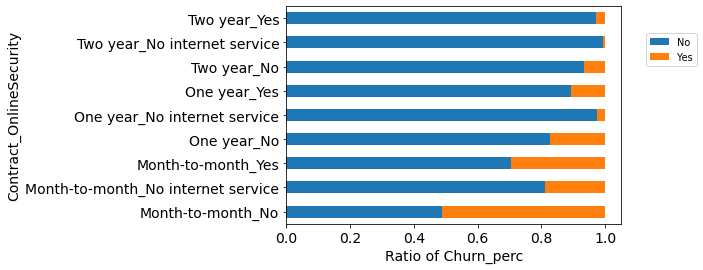

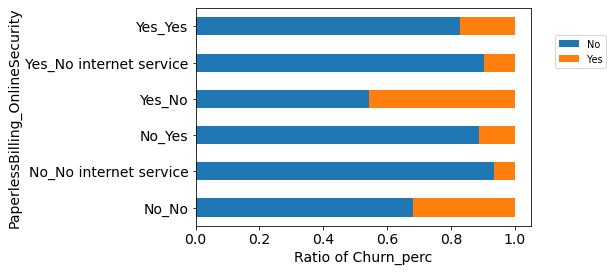

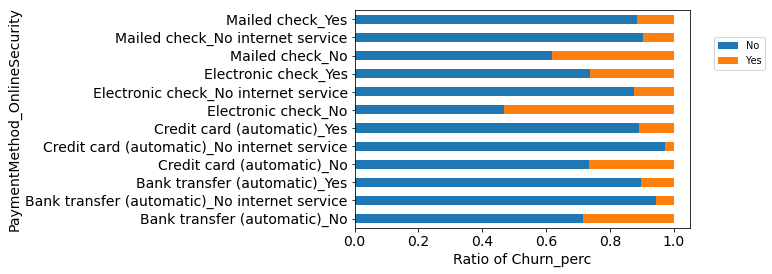

ValueError: cannot insert Churn, already exists

In [21]:
catvscat_hued(obj_cols,'OnlineSecurity','Churn')

##### 9. OnlineBackup

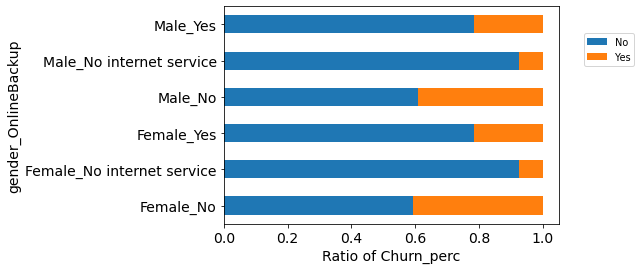

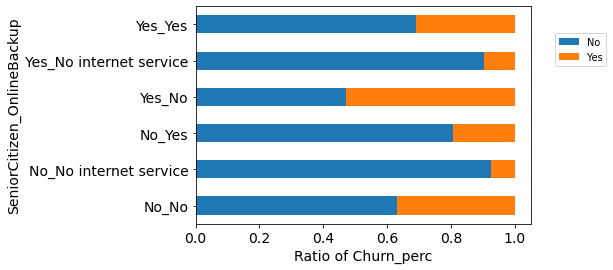

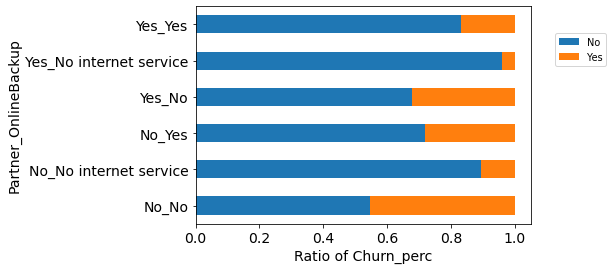

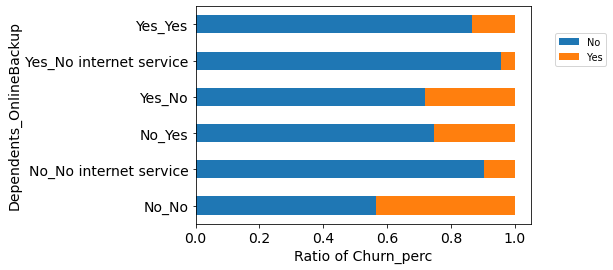

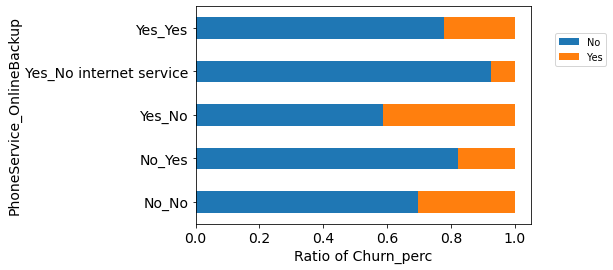

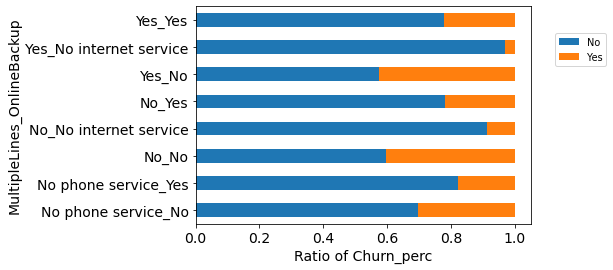

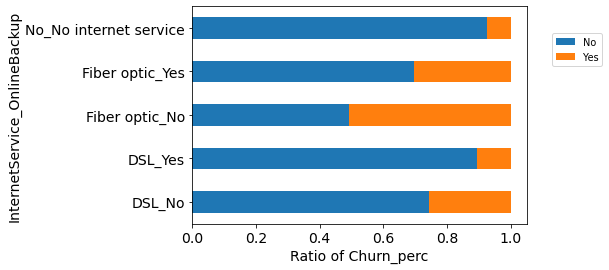

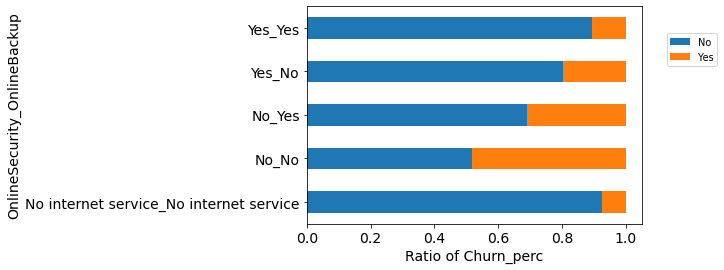

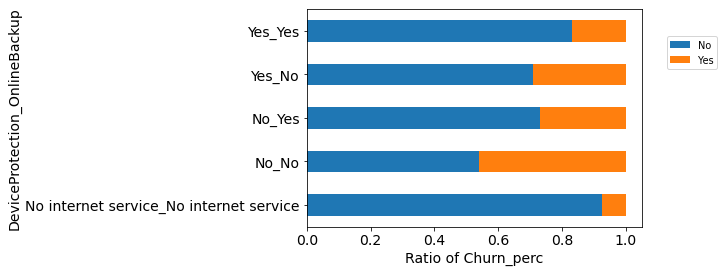

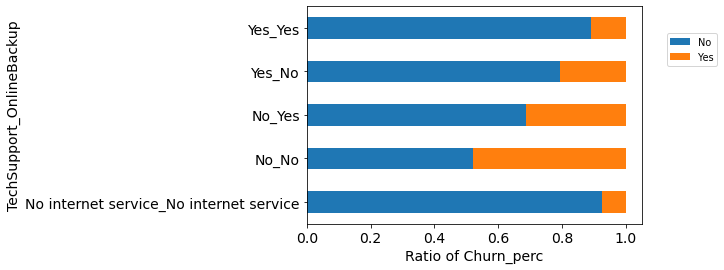

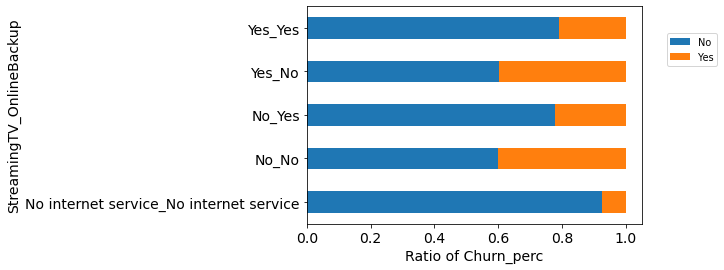

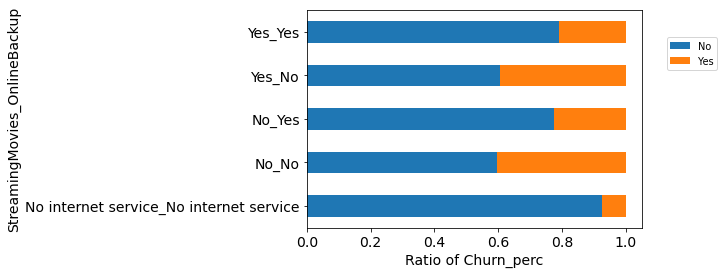

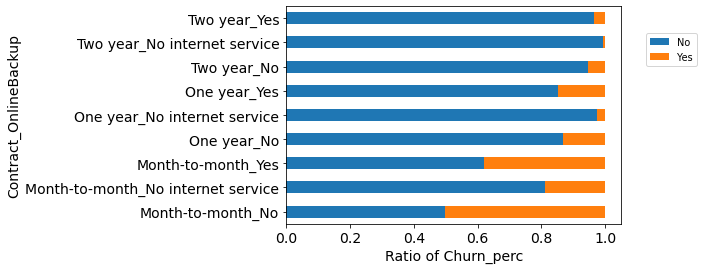

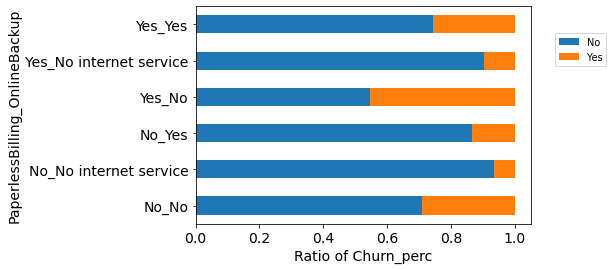

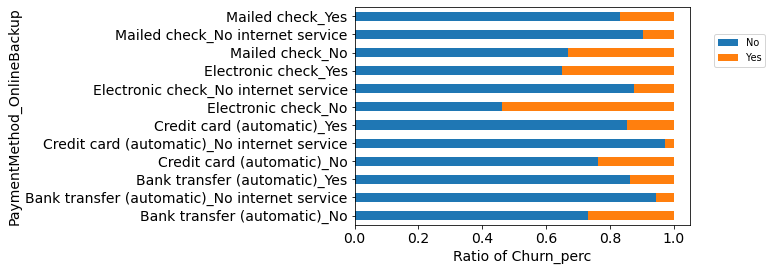

ValueError: cannot insert Churn, already exists

In [22]:
catvscat_hued(obj_cols,'OnlineBackup','Churn')

##### 10. DeviceProtection

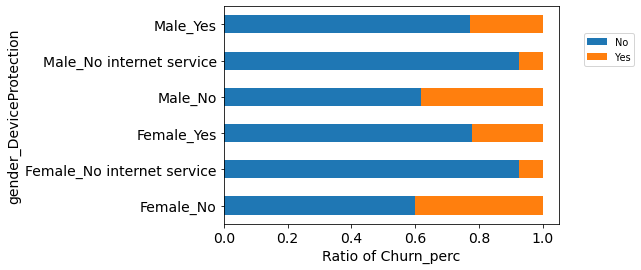

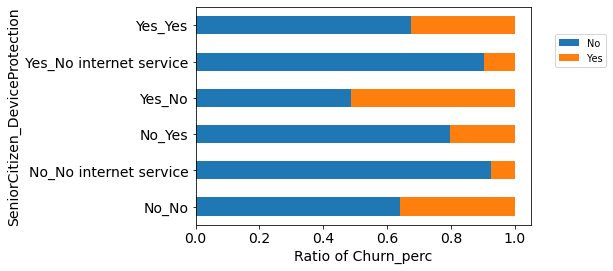

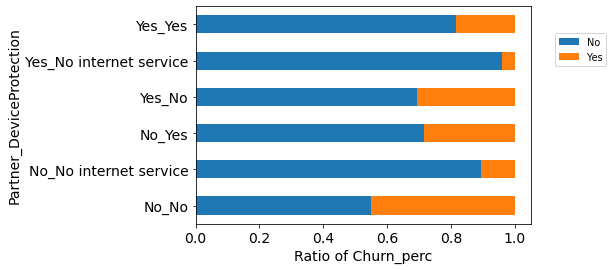

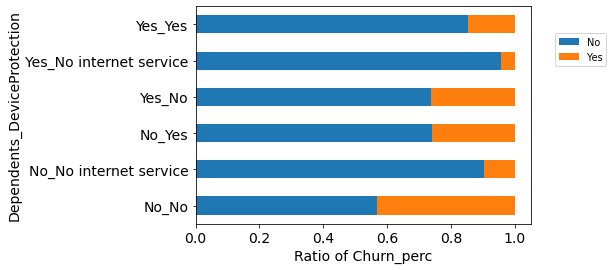

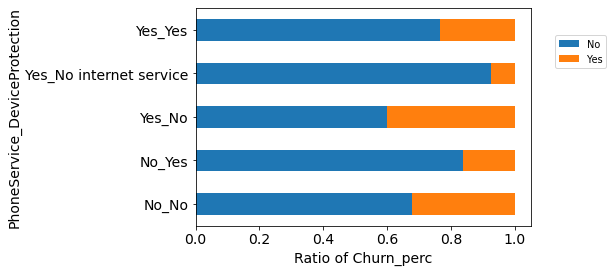

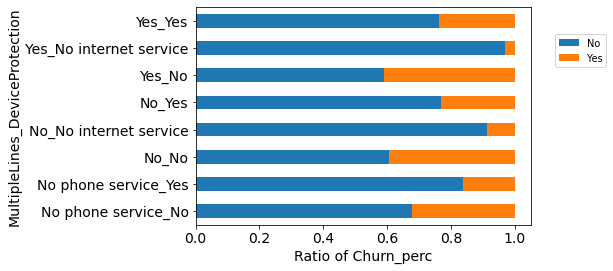

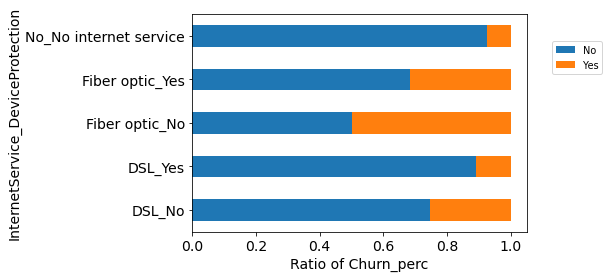

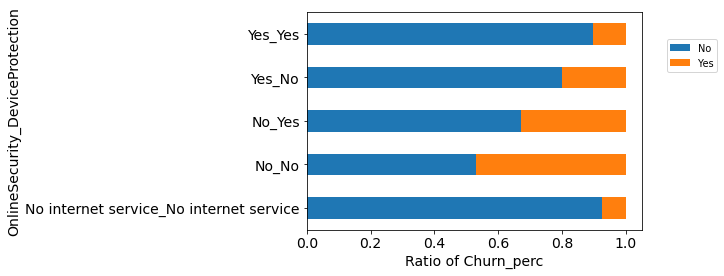

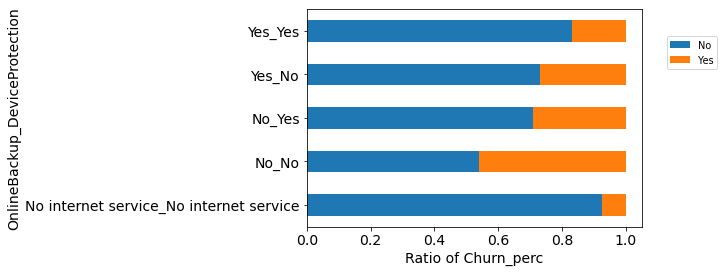

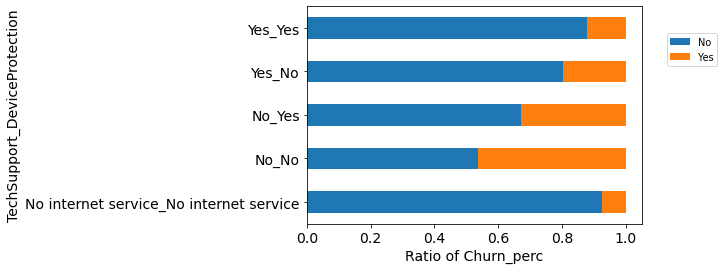

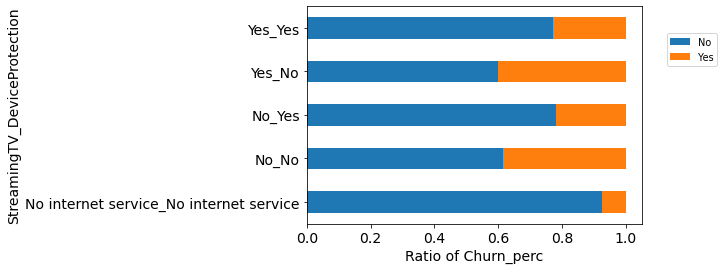

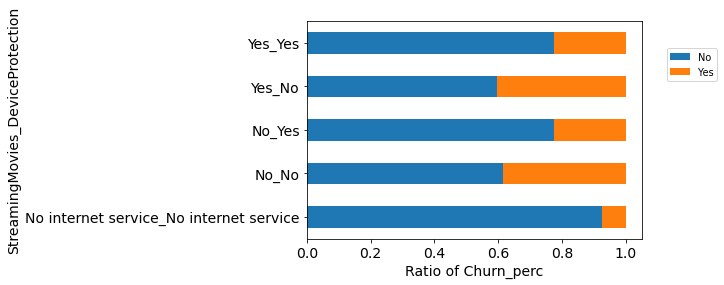

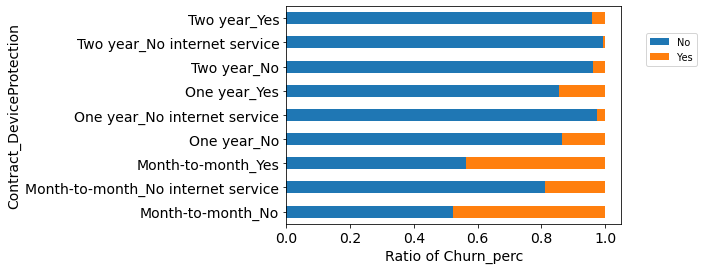

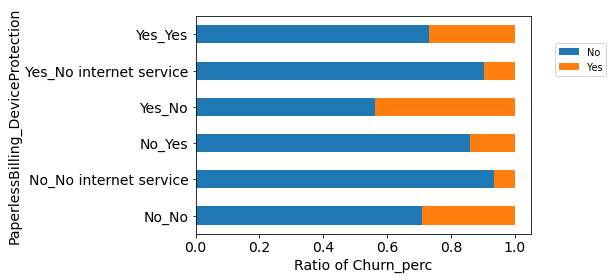

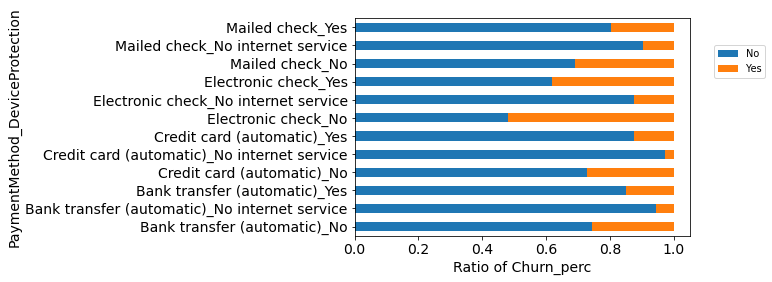

ValueError: cannot insert Churn, already exists

In [23]:
catvscat_hued(obj_cols,'DeviceProtection','Churn')

##### 11. TechSupport

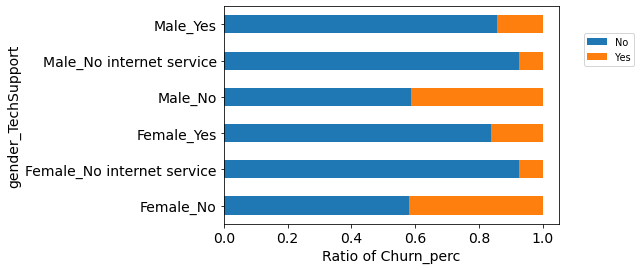

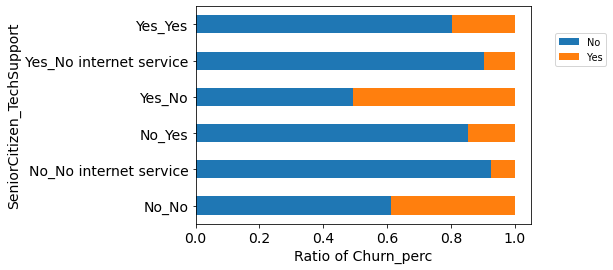

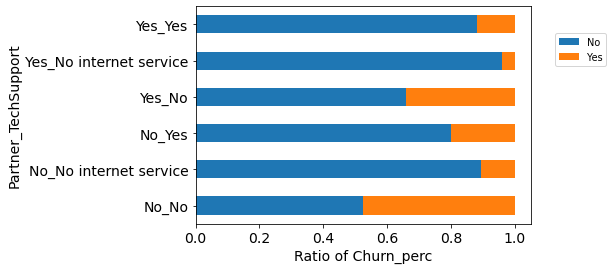

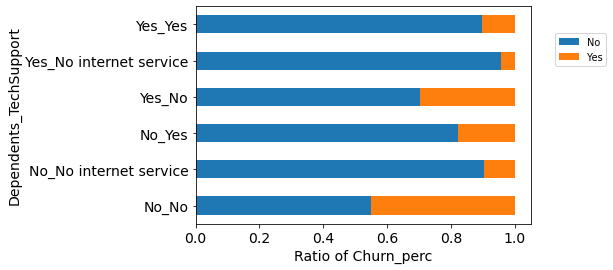

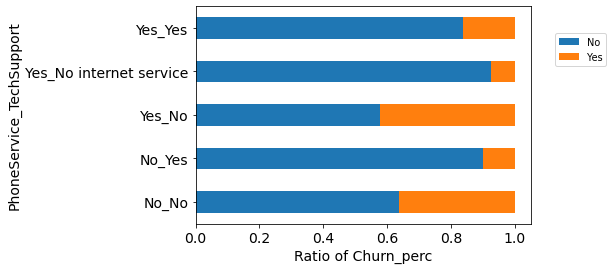

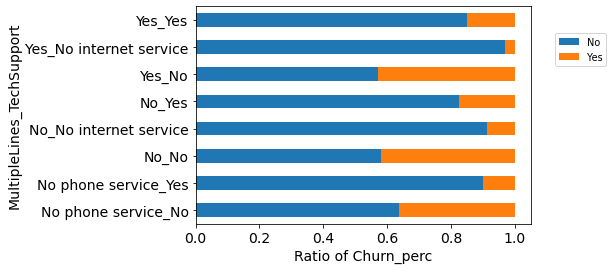

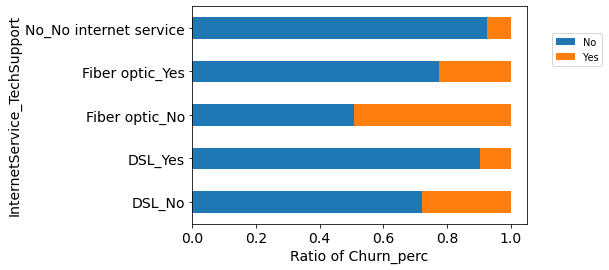

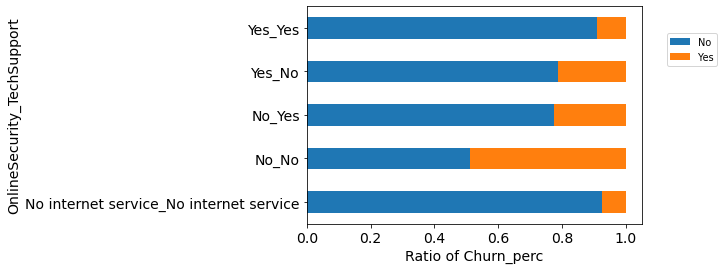

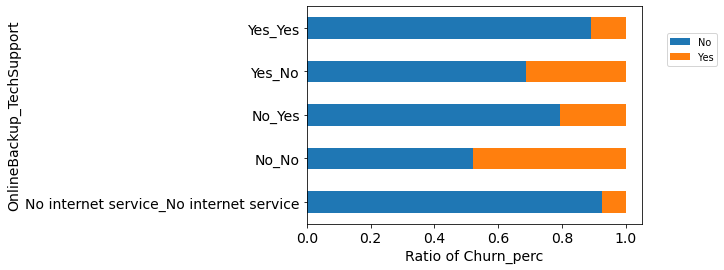

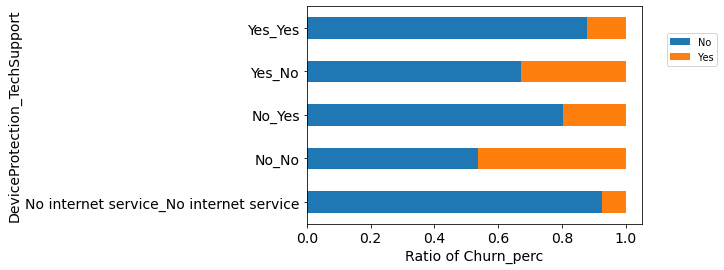

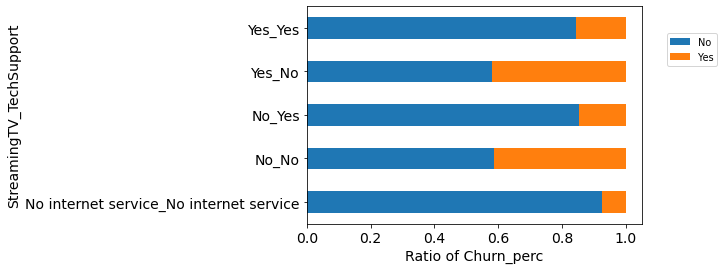

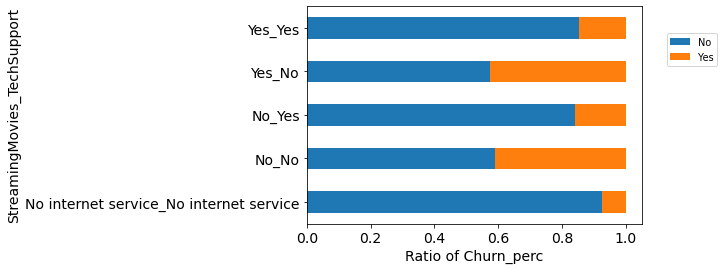

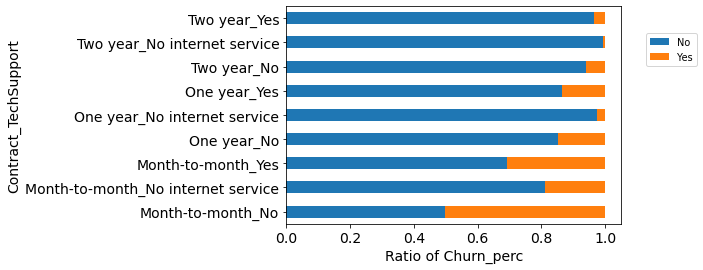

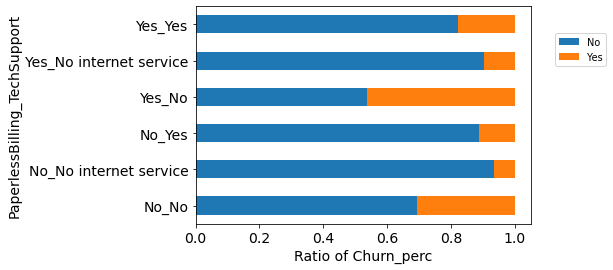

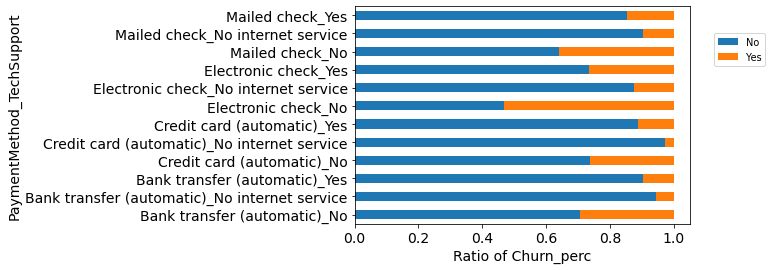

ValueError: cannot insert Churn, already exists

In [24]:
catvscat_hued(obj_cols,'TechSupport','Churn')

##### 12. StreamingTV

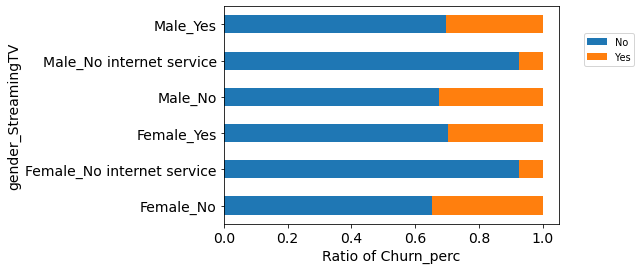

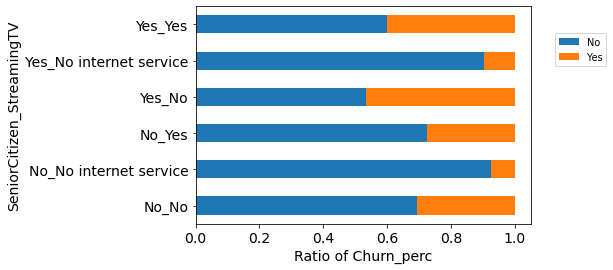

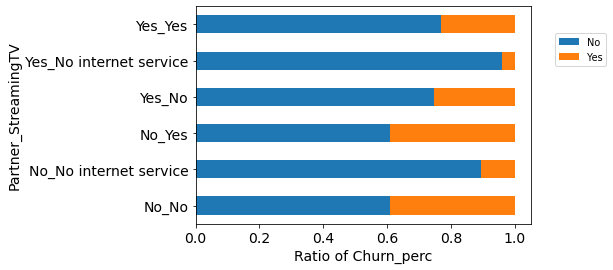

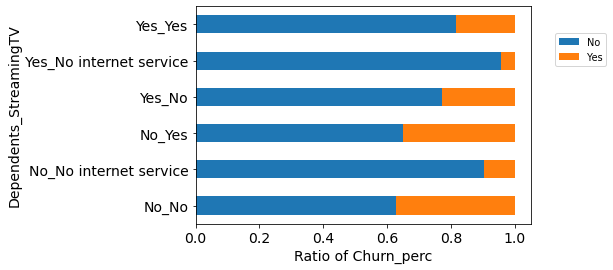

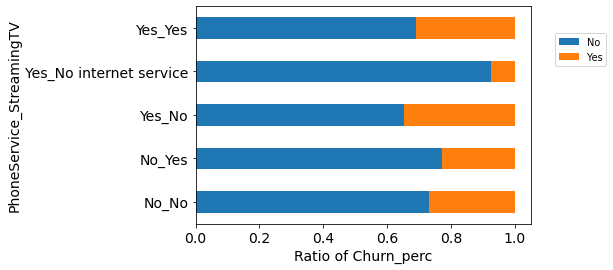

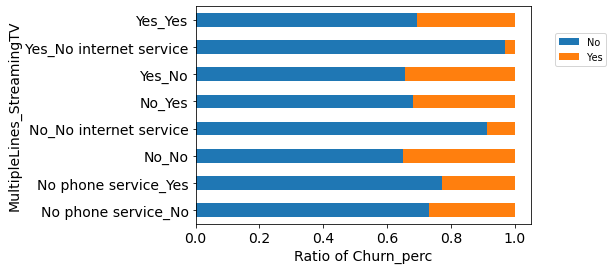

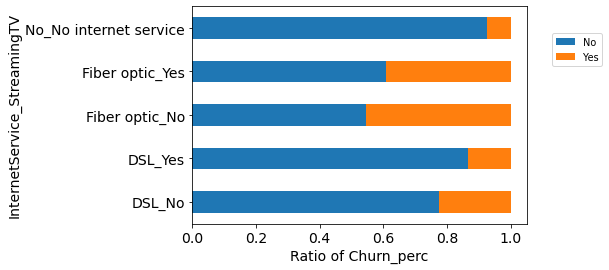

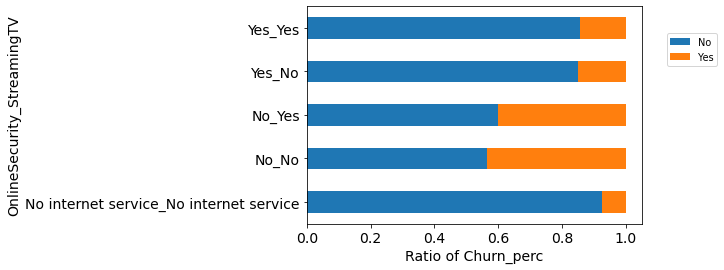

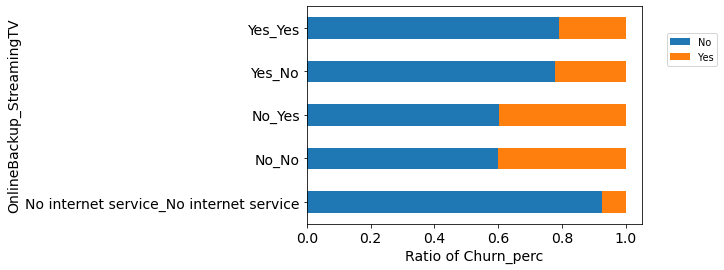

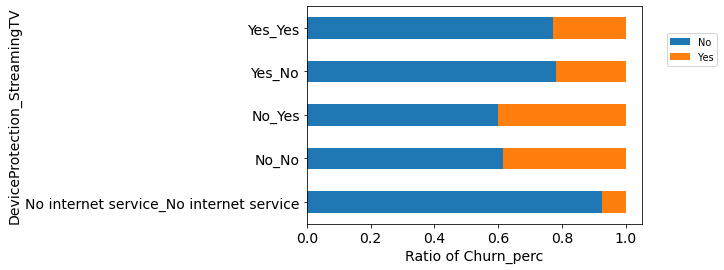

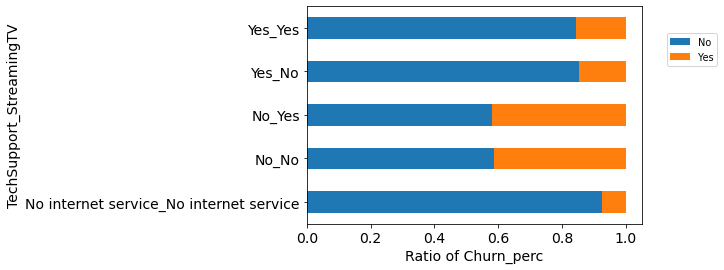

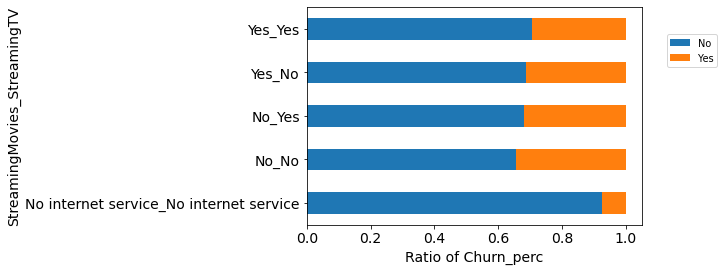

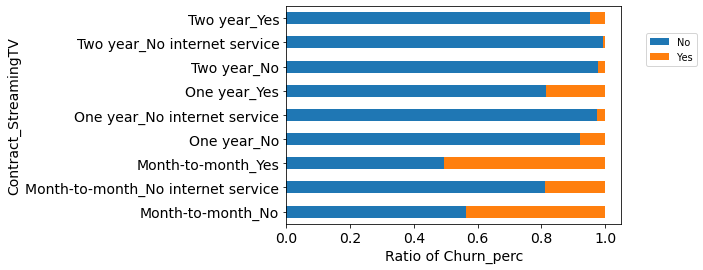

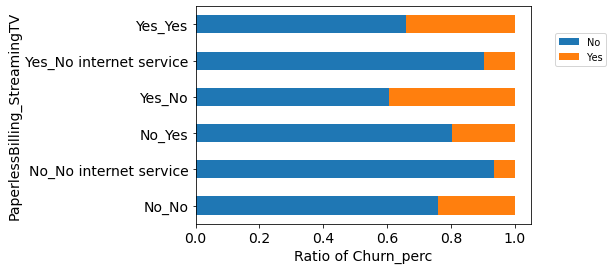

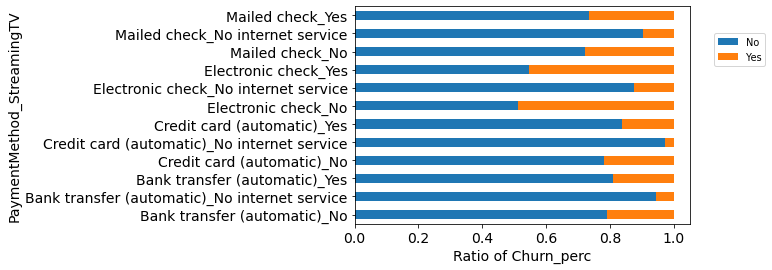

ValueError: cannot insert Churn, already exists

In [25]:
catvscat_hued(obj_cols,'StreamingTV','Churn')

##### 13. StreamingMovies

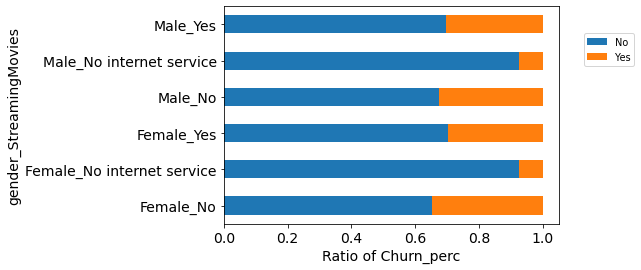

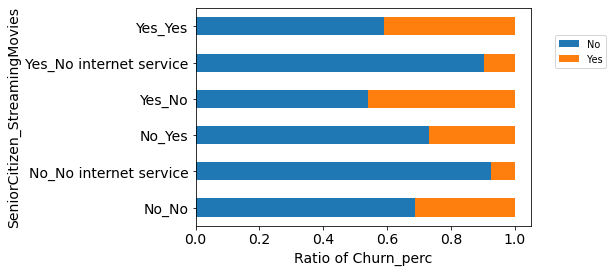

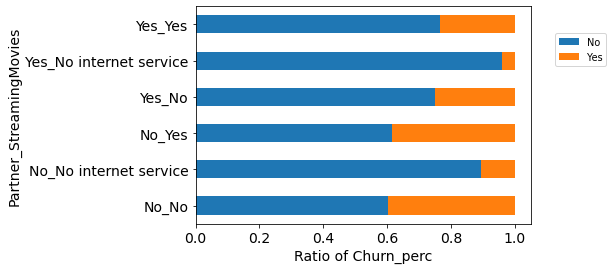

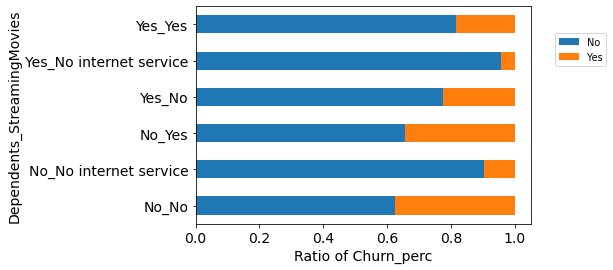

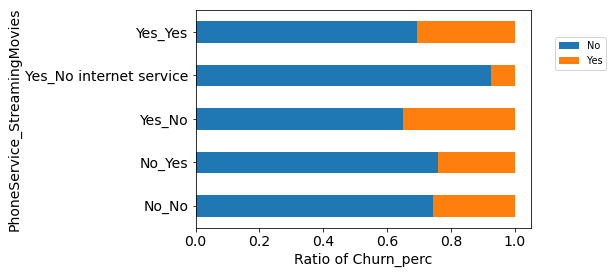

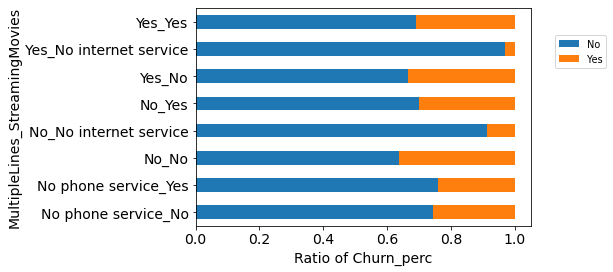

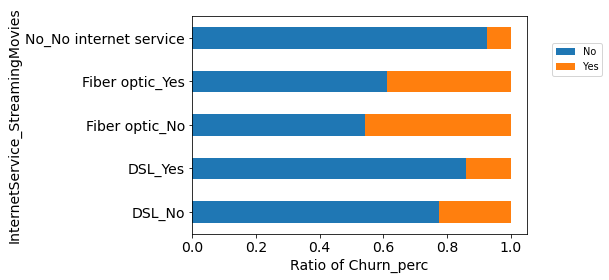

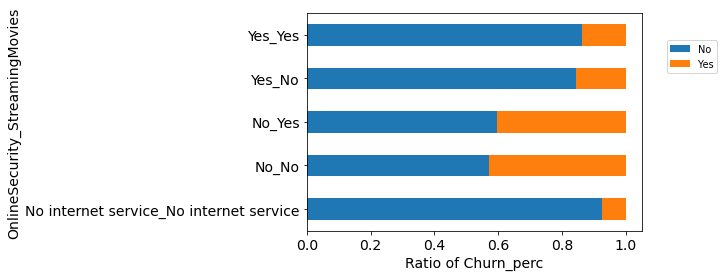

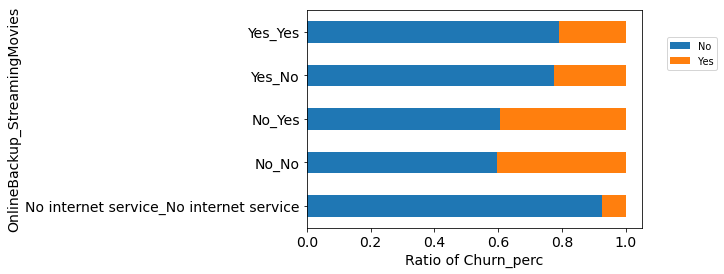

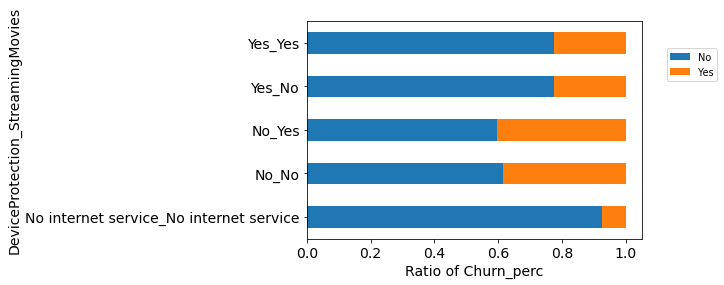

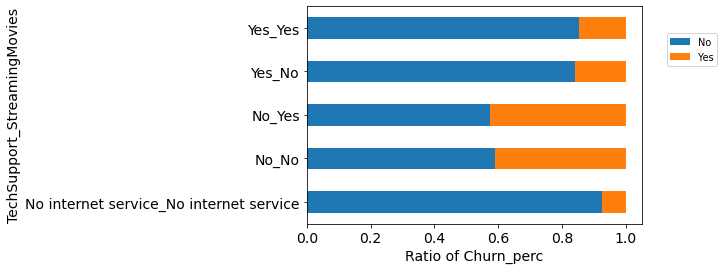

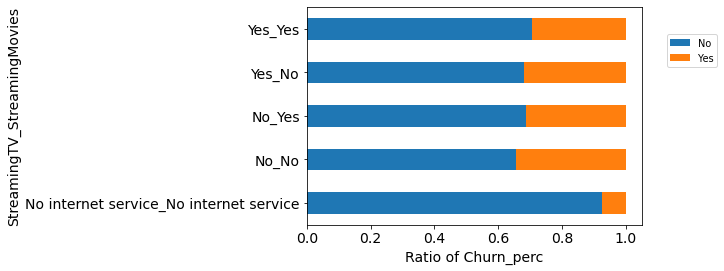

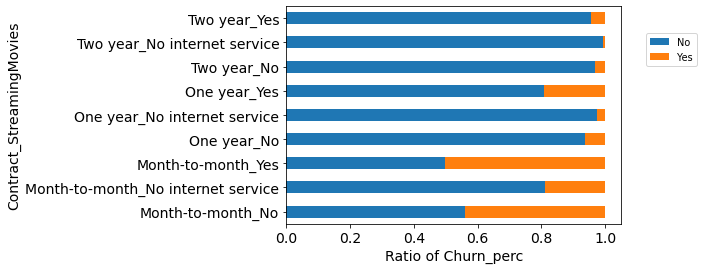

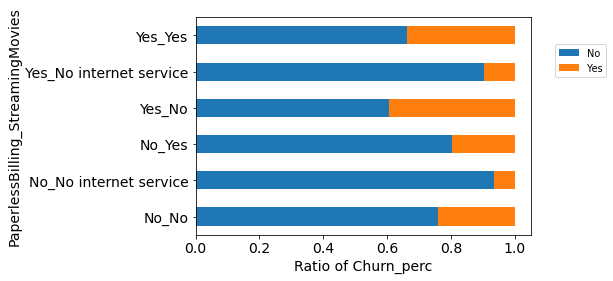

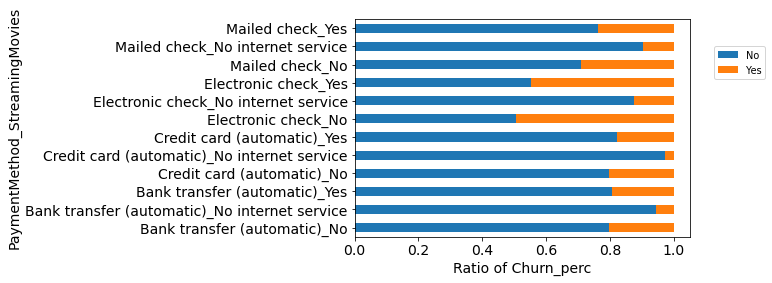

ValueError: cannot insert Churn, already exists

In [26]:
catvscat_hued(obj_cols,'StreamingMovies','Churn')

##### 14. Contract

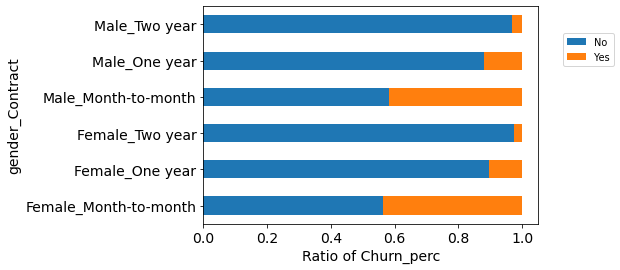

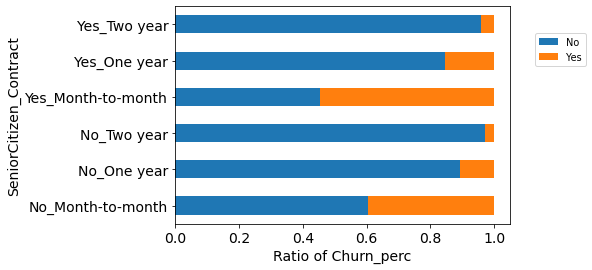

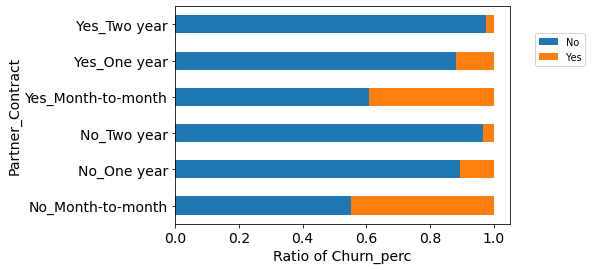

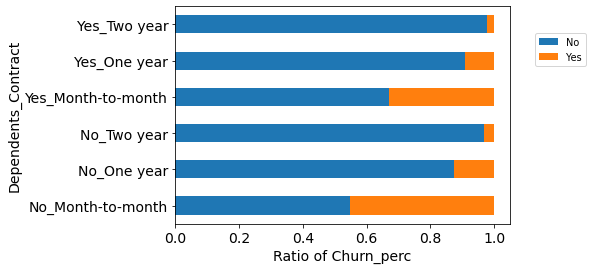

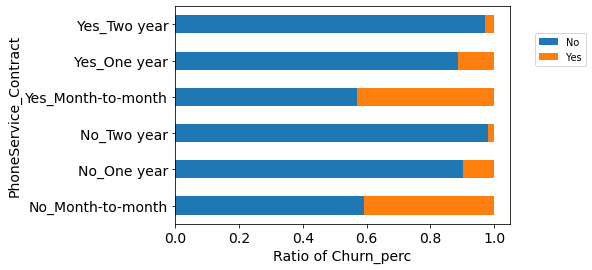

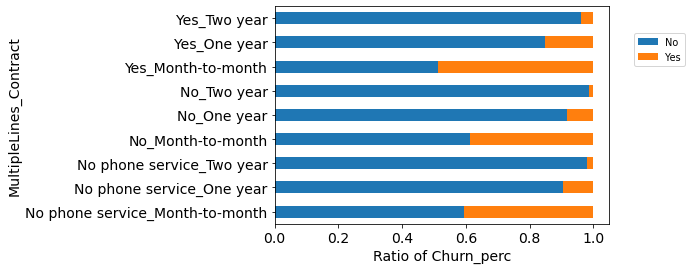

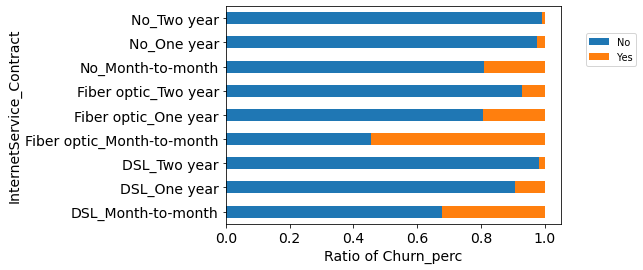

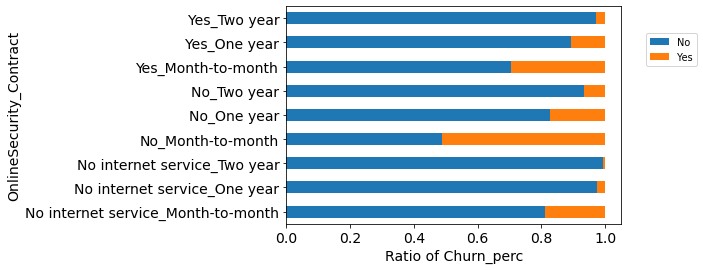

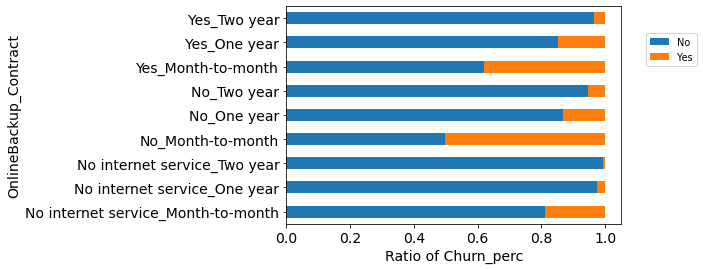

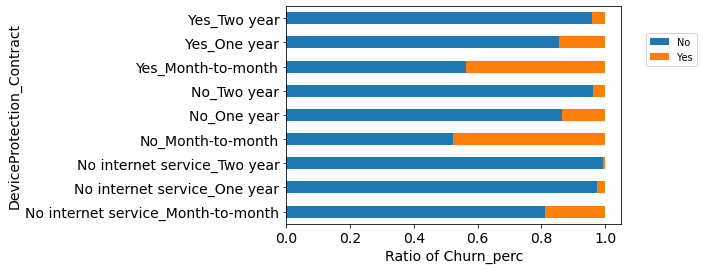

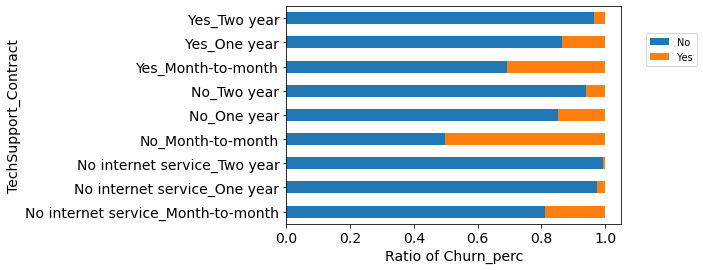

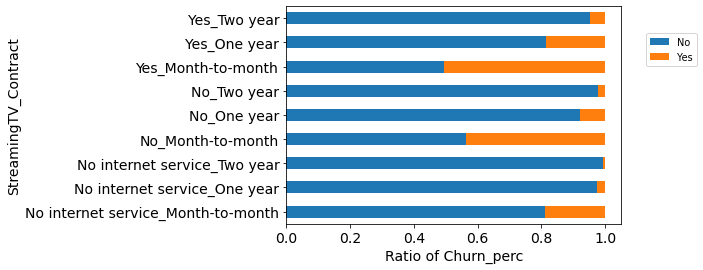

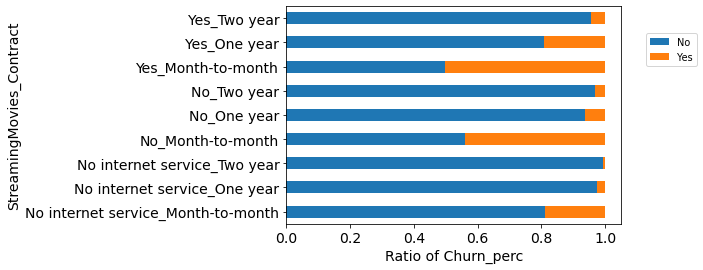

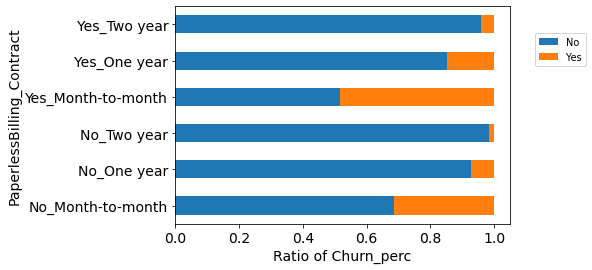

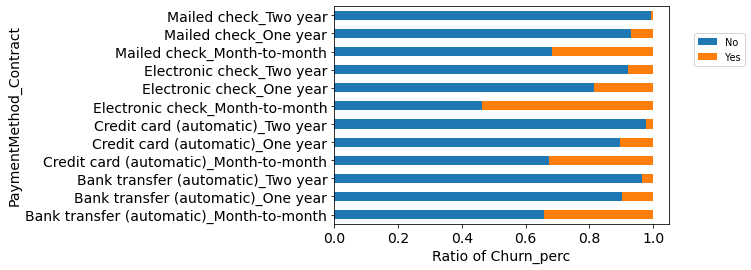

ValueError: cannot insert Churn, already exists

In [27]:
catvscat_hued(obj_cols,'Contract','Churn')

##### 15. PaperlessBilling

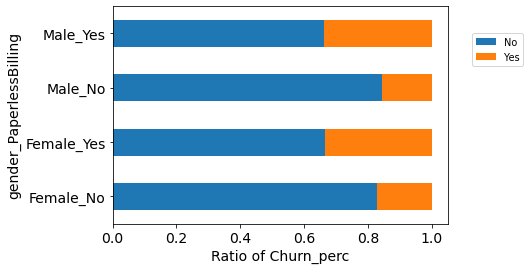

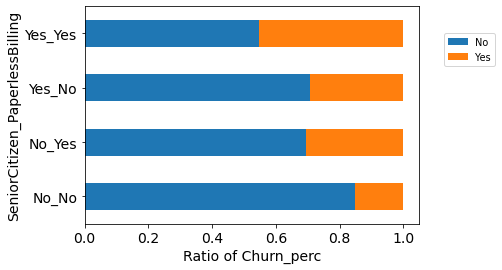

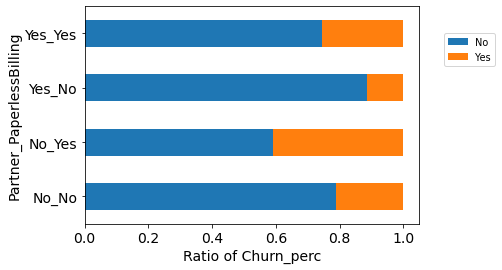

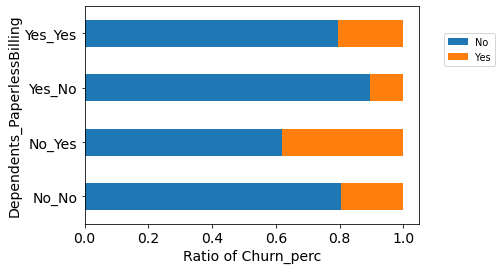

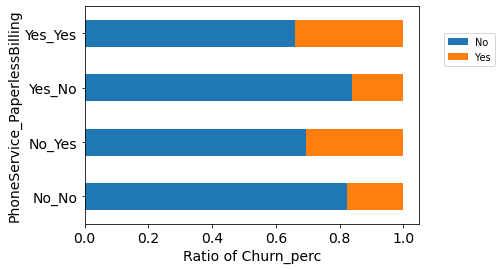

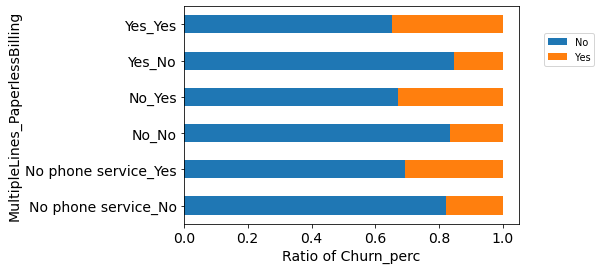

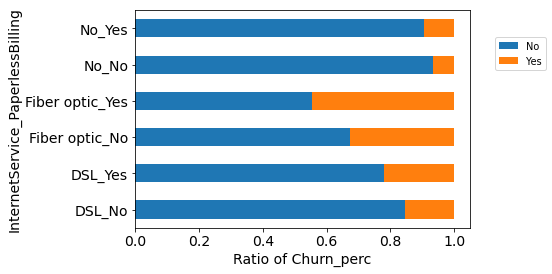

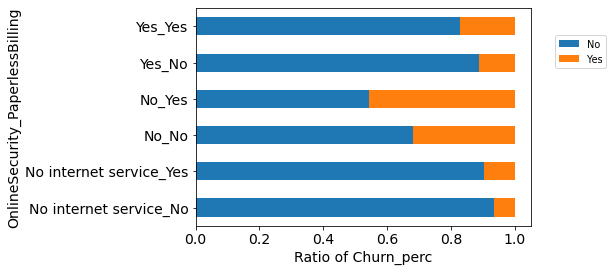

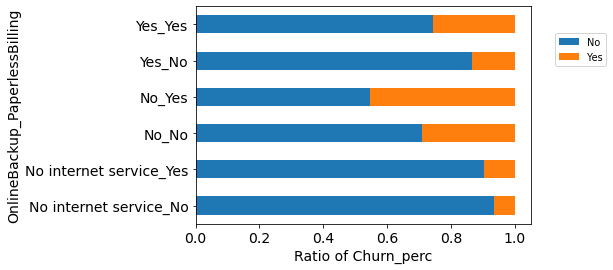

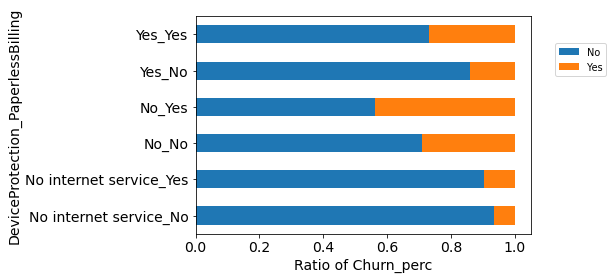

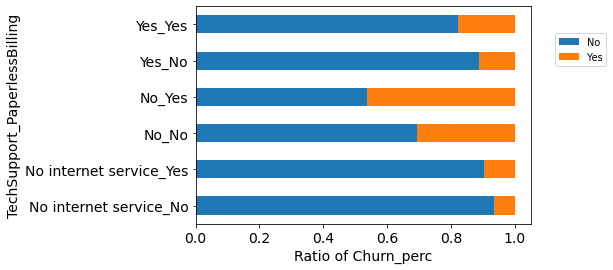

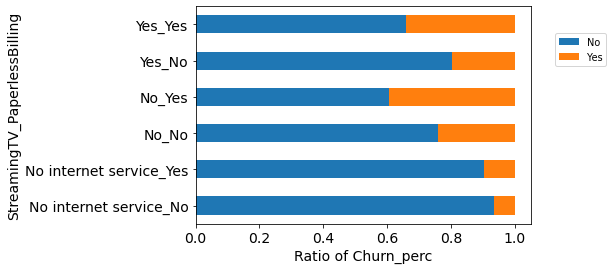

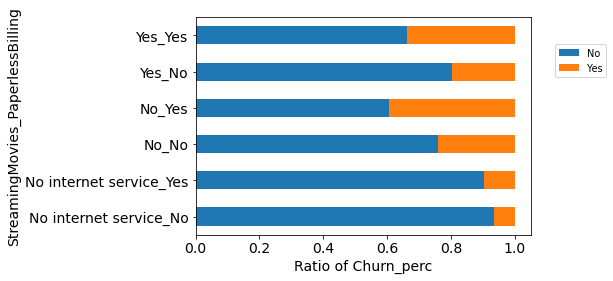

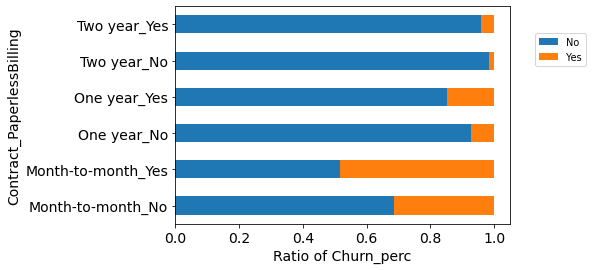

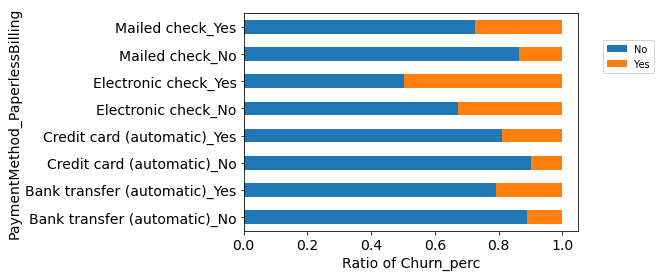

ValueError: cannot insert Churn, already exists

In [28]:
catvscat_hued(obj_cols,'PaperlessBilling','Churn')

##### 16. PaymentMethod

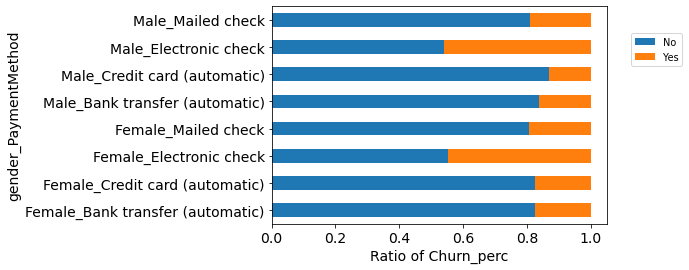

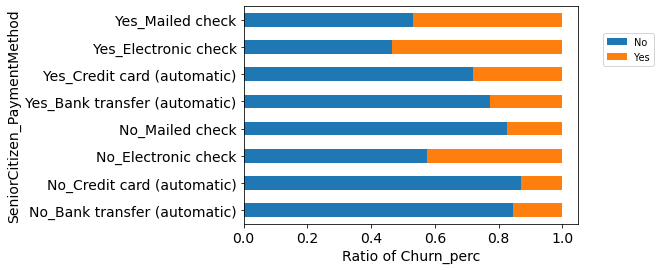

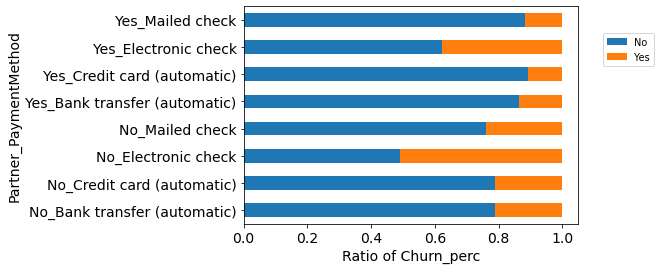

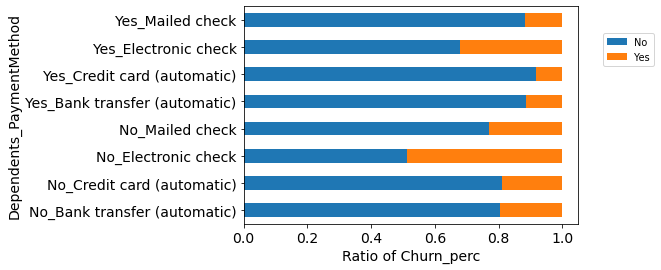

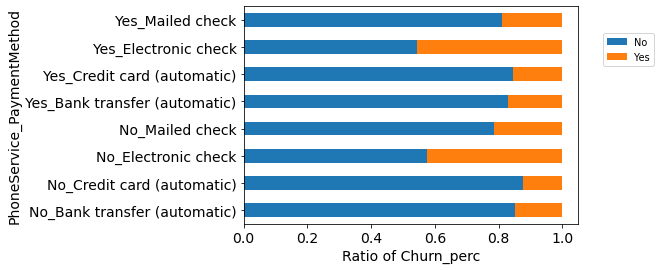

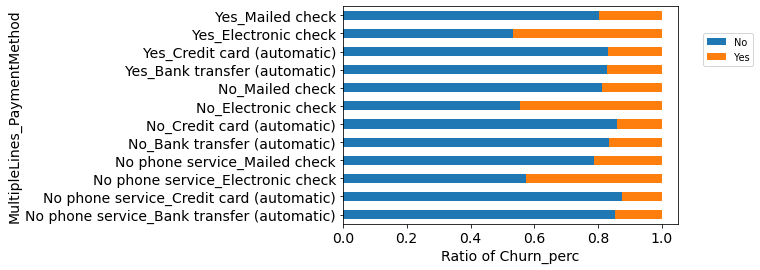

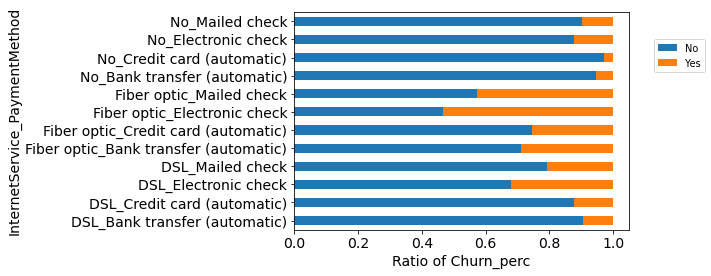

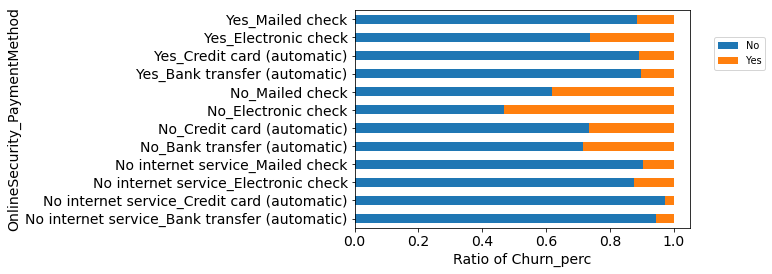

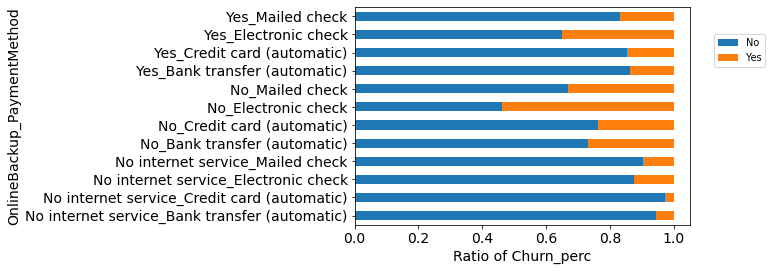

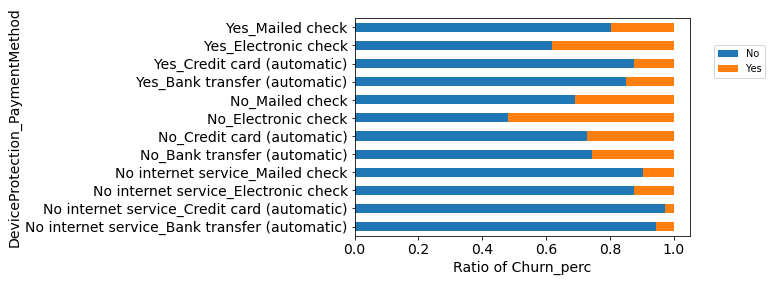

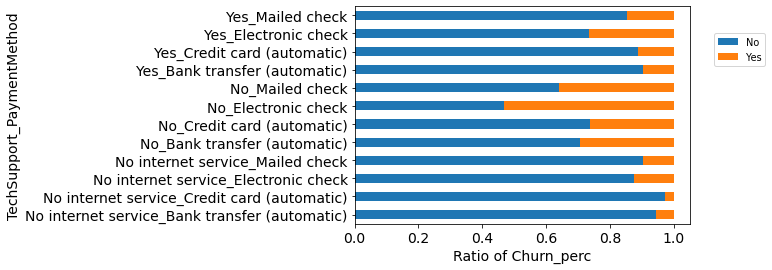

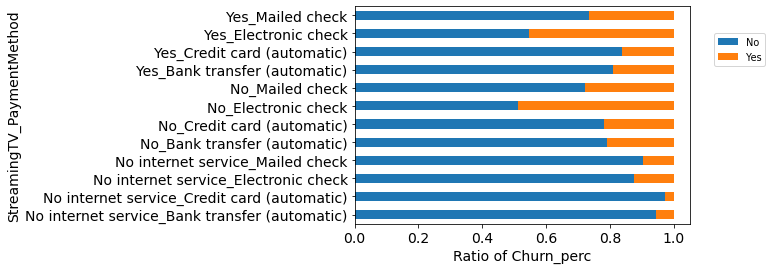

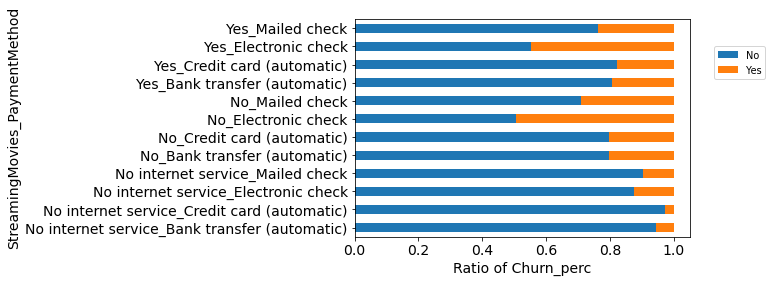

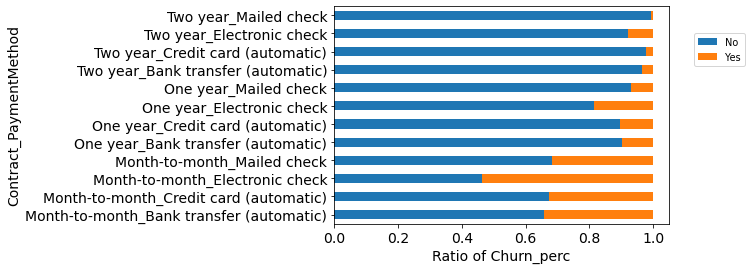

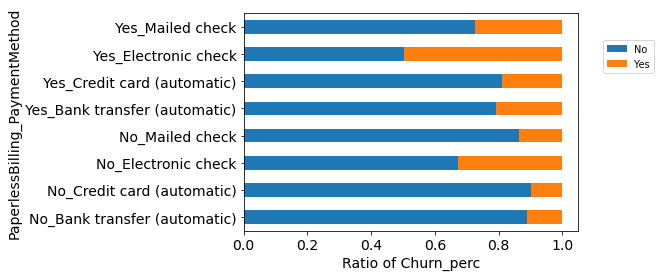

ValueError: cannot insert Churn, already exists

In [29]:
catvscat_hued(obj_cols,'PaymentMethod','Churn')

In [ ]:
catvscat_hued(obj_cols,'SeniorCitizen','Churn')

In [ ]:
catvscat_hued(imp_cols_cat,'InternetService','Churn')